<img src="header-text-classification.png"/>

# Execution du notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

```bash
├───data
│   ├───processed
│   │   └───data_01.pkl
│   ├───raw
│   │   ├───flipkart_com-ecommerce_sample_1050.csv
│   │   └───images/*.jpg
│   └───output
└───notebooks
    ├───1_exploration.ipynb
    ├───2_text_classification.ipynb
    ├───3_image_classification.ipynb
    ├───4_text+image_classification.ipynb
    ├───dumbbell.png
    ├───header-exploration.png
    ├───header-image-classification.png
    ├───header-text+image-classification.png
    ├───header-text-classification.png
    └───hook-blue.jpg
```

Les fichiers `*.pkl` sont issus de l'exécution du notebook `1_exploration.ipynb`.

# Initialisation du projet

# Project initialization

In [1]:
# Math & data
import numpy as np
import pandas as pd
import math
import os
from os import listdir
from os.path import isfile, join
import time
import itertools
import shutil
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import datetime

In [263]:
# NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText

# CV
from PIL import Image

In [6]:
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

import transformers
os.environ["TF_KERAS"]='1'

In [9]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [10]:
# Personal libraries
import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

In [11]:
LAUNCH_DOE = False

# Chargement des données

In [259]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'
data_input_dir = '../data/input/'
data_output_dir = '../data/output/'

In [21]:
file = open(data_processed_dir+'data_01.pkl','rb')
data_01 = pickle.load(file)
file.close()

# Textes - Pré-traitements

## Fonctions communes

In [13]:
# Stop words
STOP_WORDS = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', ';', '?', '!', '(', ')']
EXCLUDED_WORDS = [
    'products',
    'product',
    'free',
    'rs',
    'r',
    'buy',
    'delivery',
    'deliveri',
    'deliver',
    'cash',
    'shipping',
    'shipment',
    'ship',
    'prices',
    'price',
    'gifts',
    'gift',
    'giftings',
    'gifting',
    'gifted',
    'giving',
    'gived',
    'give',
    'gave',
    'best',
    'genuine',
    'day',
    'online',
    'india',
    'number',
    'key',
    'feature',
    'replacement',
    'guarantee',
    'discount',
    'sale',
    'specification',    
    ]

In [14]:
MIN_WORD_LEN = 1 # "HD" est informatif

In [15]:
def tokenizer_fct(sentence):
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def lower_fct(list_words):
    lower_words = [w.lower() for w in list_words]
    return lower_words

def stop_word_filter_fct(list_words):
    filtered_w1 = excluded_words_filter(list_words)
    filtered_w2 = [w for w in filtered_w1 if not w in STOP_WORDS]
    filtered_w3 = [w for w in filtered_w2 if len(w) > MIN_WORD_LEN]
    return filtered_w3

def excluded_words_filter(list_words):
    filtered_w = [w for w in list_words if not w in EXCLUDED_WORDS]
    return filtered_w

# Bon début
def start_fct(list_words):
    lw = [w for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Alphanumérique
def alpha_fct(list_words):
    alpha_tokens = [w for w in list_words if w.isalpha()]
    return alpha_tokens

# Lemmatizer (base d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Stemmatizer (autre base d'un mot)
def stem_fct(list_words):
    stemmatizer = PorterStemmer()
    stem_w = [stemmatizer.stem(w) for w in list_words]
    return stem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    st = start_fct(lw)
    transf_desc_text = ' '.join(st)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatisation
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    st = start_fct(sw)
    lem_w = lemma_fct(st)
    lem_w = excluded_words_filter(lem_w)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec stemmatisation
def transform_bow_stem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    st = start_fct(sw)
    stem_w = stem_fct(st)
    stem_w = excluded_words_filter(stem_w)
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    st = start_fct(lw)
    transf_desc_text = ' '.join(st)
    return transf_desc_text

'gift' est bien filtré, mais pas 'gifts', dont le lemme ou stem **redonne** 'gift'

In [16]:
def token_is_in_cluster_number(df, token, n_clust, text_col='name_AND_description', clust_col='label'):
    nb_sample_yes = df.loc[ (df[clust_col]==n_clust) &  (df[text_col].str.contains(token))].shape[0]
    nb_sample_clust = df.loc[ (df[clust_col]==n_clust) ].shape[0]
    nb_sample_tot = df.shape[0]
    
    print(f"Le token "+bcolors.BOLD+f"{token}"+bcolors.ENDC+f" est présent dans {nb_sample_yes} samples sur {nb_sample_clust} dans le cluster {n_clust} et sur {nb_sample_tot} samples au total")
    

## Nettoyage et préparation du texte

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a072108\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
transf_cols = {'sentence_bow': transform_bow_fct,
               'sentence_bow_lem': transform_bow_lem_fct,
               'sentence_bow_stem': transform_bow_stem_fct,
               'sentence_dl': transform_dl_fct}

In [19]:
def create_transformed_columns(df0, transf_cols, text_col):
    df = df0.copy()
    for col in transf_cols:
        fct = transf_cols[col]
        df[col] = df[text_col].apply(fct)
    return df

In [22]:
data_02 = create_transformed_columns(data_01, transf_cols, 'name_AND_description')
data_02

categs_1st                                 categs_2nd  \
0     Home Furnishing  Home Furnishing >> Curtains & Accessories   
1           Baby Care              Baby Care >> Baby Bath & Skin   
2           Baby Care              Baby Care >> Baby Bath & Skin   
3     Home Furnishing               Home Furnishing >> Bed Linen   
4     Home Furnishing               Home Furnishing >> Bed Linen   
...               ...                                        ...   
1045        Baby Care             Baby Care >> Baby & Kids Gifts   
1046        Baby Care             Baby Care >> Baby & Kids Gifts   
1047        Baby Care             Baby Care >> Baby & Kids Gifts   
1048        Baby Care             Baby Care >> Baby & Kids Gifts   
1049        Baby Care             Baby Care >> Baby & Kids Gifts   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                   name_AND_description  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1     Sathiyas Cotton Bath Towel Specifications of S...   
2     Eurospa Cotton Terry Face Towel Set Key Featur...   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker Wallman...   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048  Wallmantra Medium Vinyl Sticker Sticker Buy Wa...   
1049  Uberlyfe Large Vinyl Sticker Buy Uberlyfe Larg...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                           sentence_bow  \
0     elegance polyester multicolor abstract eyelet ...   
1     sathiyas cotton bath towel specifications of s...   
2     eurospa cotton terry face towel set key featur...   
3     santosh royal fashion cotton printed king size...   
4     jaipur print cotton floral king sized double b...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
1046  wallmantra large vinyl sticker sticker wallman...   
1047  uberlyfe extra large pigmented polyvinyl films...   
1048  wallmantra medium vinyl sticker sticker buy wa...   
1049  uberlyfe large vinyl sticker buy uberlyfe larg...   

                                       sentence_bow_lem  \
0     elegance polyester multicolor abstract eyelet ...   
1     sathiyas cotton bath towel sathiyas cotton bat...   
2     eurospa cotton terry face towel set eurospa co...   
3     santosh royal fashion cotton printed king size...   
4     jaipur print cotton floral king sized double b...   
...                                                 ...   
1045  oren empower extra large self adhesive sticker...   
1046  wallmantra large vinyl sticker stick

`'os'` se fait lemmatiser en `'o'` !

### Tokens rares

Les tokens rares sont fonction de la colonne transformée.

In [28]:
def list_lt_or_gt_n_words(df, n, col, op='lt'):
    corpus = ' '.join(list(df[col].values))
    all_words = corpus.split(' ')
    tmp = pd.Series(all_words).value_counts()
    if op == 'lt':
        list_m = tmp[tmp<=n]
    else:
        list_m = tmp[tmp>=n]
        
    print(list_m)
    return list_m

In [29]:
n = 5
lt_n_words = {}
all_lt_n_words = pd.DataFrame()
print(f"Taille de la liste des mots rares (<={n}): ")
for col in transf_cols:
    lt_n_words[col] = list_lt_or_gt_n_words(data_02, n, col, op='lt')
    lt_n_words[col].to_csv(f"tokens_lt_{n}_{col}.csv", sep=';')
    print(f"{col}: {lt_n_words[col].shape[0]}")
    df = pd.DataFrame(lt_n_words[col])
    df['col'] = col
    all_lt_n_words = pd.concat([all_lt_n_words, df])
    print(all_lt_n_words)
all_lt_n_words.to_csv(f"tokens_lt_{n}_ALL.csv", sep=';')


Taille de la liste des mots rares (<=5): 
plating       5
chocoberry    5
location      5
qibla         5
rute          5
             ..
nvidia        1
geforce       1
sewing        1
machines      1
lens          1
Length: 3358, dtype: int64
sentence_bow: 3358
            0           col
plating     5  sentence_bow
chocoberry  5  sentence_bow
location    5  sentence_bow
qibla       5  sentence_bow
rute        5  sentence_bow
...        ..           ...
nvidia      1  sentence_bow
geforce     1  sentence_bow
sewing      1  sentence_bow
machines    1  sentence_bow
lens        1  sentence_bow

[3358 rows x 2 columns]
fast           5
location       5
zora           5
perfection     5
minimum        5
              ..
disguised      1
superheroes    1
bling          1
o              1
pal            1
Length: 2995, dtype: int64
sentence_bow_lem: 2995
             0               col
plating      5      sentence_bow
chocoberry   5      sentence_bow
location     5      sentence_bow
qibla 

In [30]:
'o' in STOP_WORDS

True

In [31]:
'for' in STOP_WORDS

True

### Tokens les plus fréquents

Ils peuvent être également source de bruit alors qu'ils ne portent pas d'information. Voyons si les stop words les ont captés.

In [32]:
n = 500
gt_n_words = {}
all_gt_n_words = pd.DataFrame()
print(f"Taille de la liste des mots fréquents (>={n}): ")
for col in transf_cols:
    gt_n_words[col] = list_lt_or_gt_n_words(data_02, n, col, op='gt')
    gt_n_words[col].to_csv(f"tokens_gt_{n}_{col}.csv", sep=';')
    print(f"{col}: {gt_n_words[col].shape[0]}")
    df = pd.DataFrame(gt_n_words[col])
    df['col'] = col
    all_gt_n_words = pd.concat([all_gt_n_words, df])
    print(all_gt_n_words)
all_gt_n_words.to_csv(f"tokens_gt_{n}_ALL.csv", sep=';')
    

Taille de la liste des mots fréquents (>=500): 
of             1788
for            1605
the            1377
and            1374
to             1058
in             1049
only            889
with            889
on              840
at              714
a               689
your            658
cm              652
is              640
products        633
free            621
rs              592
buy             582
replacement     568
delivery        567
cash            564
genuine         564
shipping        564
day             543
dtype: int64
sentence_bow: 24
                0           col
of           1788  sentence_bow
for          1605  sentence_bow
the          1377  sentence_bow
and          1374  sentence_bow
to           1058  sentence_bow
in           1049  sentence_bow
only          889  sentence_bow
with          889  sentence_bow
on            840  sentence_bow
at            714  sentence_bow
a             689  sentence_bow
your          658  sentence_bow
cm            652  sentenc

Ces tokens fréquents permettent d'éliminer les suivants : 

In [33]:
NEW_EXCLUDED_WORDS = [
    'products',
    'product',
    'free',
    'rs',
    'r',
    'buy',
    'delivery',
    'deliveri',
    'deliver',
    'cash',
    'shipping',
    'shipment',
    'ship',
    'prices',
    'price',
    'gifts',
    'gift',
    'giftings',
    'gifting',
    'gifted',
    'giving',
    'gived',
    'give',
    'gave',
    ]

In [34]:
stem_fct(['gifting'])

['gift']

In [35]:
lemma_fct(['gifting'])

['gifting']

On repasse les fonctions, maintenant que la liste des mots à exclure est plus riche :

In [36]:
data_03 = create_transformed_columns(data_01, transf_cols, 'name_AND_description')

In [37]:
data_03.to_csv("data_03.csv", sep=';')

In [38]:
df_tk = data_03.copy()

## Catégories de produits

On va fixer les labels selon les premiers résultats de word2vec, pour faciliter les visualisations par couleur :

In [39]:
print(df_tk['categs_1st'].unique())

['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


In [40]:
categ_map = {
    'Watches': 0,
    'Computers': 1,
    'Baby Care': 2,
    'Home Furnishing': 3,
    'Home Decor & Festive Needs': 4,
    'Kitchen & Dining': 5,
    'Beauty and Personal Care': 6
}

In [41]:
def renum_label(row):
    return categ_map[row]

def relabel_categs(df0):
    df = df0.copy()
    df['categs_1st_num'] = df['categs_1st'].apply(renum_label)
    return df

In [42]:
df_tk = relabel_categs(df_tk)

In [43]:
df_tk['categs_1st_num']

0       3
1       2
2       2
3       3
4       3
       ..
1045    2
1046    2
1047    2
1048    2
1049    2
Name: categs_1st_num, Length: 1050, dtype: int64

## Wordcloud

In [45]:
all_sentences = ' '.join(df_tk['sentence_bow'].values)

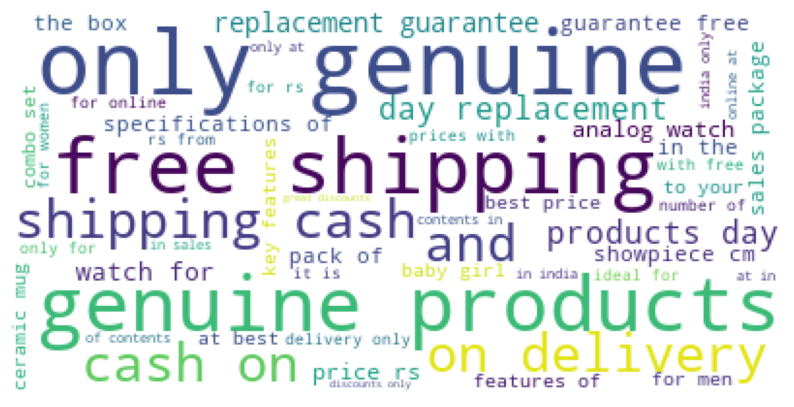

In [46]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
wordcloud = WordCloud(
    background_color='white',
    stopwords=[], # inutile après notre travail
    max_words=50,
#     collocation_threshold=1,
# ).generate(all_sentences)
).generate_from_text(all_sentences)

plt.imshow(wordcloud)
plt.axis('off')
plt.xlabel('Avant ajout de stopwords')
plt.show();

A de rares exceptions près, `key` vient avec `feature`, et vice versa. Détecter les bigrammes et éliminer ceux qui n'apportent rien est donc une bonne idée.

In [47]:
all_sentences = ' '.join(df_tk['sentence_bow_lem'].values)

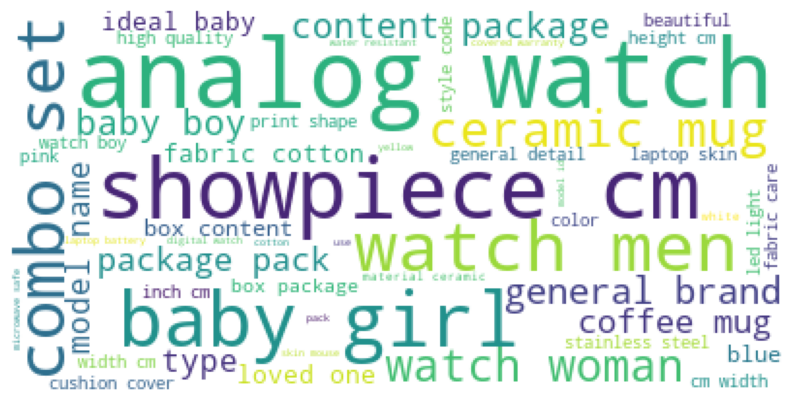

In [48]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=EXCLUDED_WORDS,
    max_words=50,
#     collocation_threshold=1,
# ).generate(all_sentences)
).generate_from_text(all_sentences)

plt.imshow(wordcloud)
plt.axis('off')
plt.show();

# Textes - Clustering

On suppose ne pas connaître les catégories à séparer. On va vérifier la pertinence de l'extraction des features en **segmentant** les descriptions.

## Fonctions communes

In [49]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, y_cat_num, n_cat, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=n_cat, n_init=100, random_state=18011975)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_tsne, cls.labels_


def ARI_fct2(features, true_labels=None, num_labels=20) :
    time1 = time.time()
    if true_labels:
        num_labels = len(true_labels)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
#     ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    ARI = 0.
    
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Calcul Tsne
def TSNE_calc_unsupervised(features, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                         init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    time2 = np.round(time.time() - time1,0)
    print(f"Time : {time2}")
    return X_tsne

def compute_clusters(X, n_clusters):
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=n_clusters, n_init=100, random_state=18011975)
    cls.fit(X)
    labels = cls.labels_
    inertia = cls.inertia_
    return labels, inertia


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, marker_size=8, title_prefix=''):
    if title_prefix: title_prefix += ' - '
    fig = plt.figure()
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=marker_size, c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie")
    plt.title(title_prefix+'Catég. réelles')
    plt.xlabel('T1')
    plt.ylabel('T2')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], s=marker_size, c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Cluster")
    plt.title(title_prefix+'Catég. identifées'+f' - ARI: {ARI:.3f}')
    plt.xlabel('T1')
    plt.ylabel('T2')
    plt.show()
    print(f"ARI : {ARI:.4f}")

    
def TSNE_visu_unsupervised(X_tsne, labels, title, cmaps=None, marker_size=8):
    label_list = np.unique(labels)
    N = len(label_list)
    if not cmaps:
        cmaps = [plt.cm.tab20c, plt.cm.jet]
        
    # Pour chaque corlormap
    for cm in cmaps:
        fig = plt.figure()
        plt.rcParams['axes.prop_cycle'] = cycler(color=cm(np.linspace(0, 1, N)))
        for label in np.unique(labels):
            selected = np.where(labels == label)
            plt.scatter(X_tsne[selected, 0], X_tsne[selected, 1], s=marker_size, label=f"Cluster {label}")
        # plt.legend(markerscale=8,prop={'size': 15})
        if len(cmaps)>1: 
            title2 = title+' ('+str(cm.name)+')'
        else:
            title2 = title
        plt.title(title2)
        plt.legend()
        plt.show(block=False)
        
        
def visu_elbow(X_tsne, n_min, n_max):
    inertia = []
    n_range = range(n_min, n_max+1, 1)
    for n_clusters in n_range:
        print(f"n_clusters = {n_clusters}... ", end='')
        lbls, inrt = compute_clusters(X_tsne, n_clusters)
        # Inertie
        inertia.append(inrt)
        print(f"inertia = {inrt:.2f}")
    
    # Plot
    fig = plt.figure()
    plt.plot(n_range, inertia)
    plt.xlabel('Nombre de clusters')
    plt.xticks(n_range)
    plt.ylabel('Inertia');
    plt.title('Coût du modèle (Inertia)')
    plt.grid('on')
    plt.show()

In [50]:
def make_image_board(files, s=3000, filename='image_board.png'):
    n_images = len(files)
    
    # On commence avec une planche carrée
    new_im = Image.new('RGB', (s, s))
    w = s
    h = s
    dw = int(w/(int(math.sqrt(n_images))+1))+1
    dh = int(h/(int(math.sqrt(n_images))+1))+1

    index = 0
    for i in range(0, w, dw):
        for j in range(0, h, dh):
            im = Image.open(files[index])
            im.thumbnail((dw, dh))
            new_im.paste(im, (j, i))
            index += 1
            if index == n_images:
                break
        if index == n_images:
            break
    # Sauvegarde
    new_im.save(filename)

In [267]:
def launch_text_clustering(feat_extractor, x_sentences, n_clusters, 
                           df_tk, X, label_col,
                           input_path, output_path,
                           image_col='image', verbose=0, create_images=False):
    """Launch text clustering."""
    
    if verbose>0:
        print('Détermination des clusters...')
    labels, inertia = compute_clusters(X, n_clusters)
    lc = label_col+'_'+feat_extractor
    df_tk[lc] = labels

    if verbose>0:
        print('Visalisation des clusters...')
    title = feat_extractor+' - Catégories identifées'
    TSNE_visu_unsupervised(X, labels, title)
    if create_images:
        create_output_images(df_tk, lc, image_col, feat_extractor,
                             input_path=data_input_dir, output_path=data_output_dir, verbose=1)
        
    return labels

In [270]:
def create_output_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print('Création des images correspondant aux clusters...')
#     prod_images = {}
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        directory = os.path.join(output_path, feat_extractor)
        if not os.path.exists(directory): os.makedirs(directory)
        filename = os.path.join(directory, f"products_{n}.png")
        make_image_board(im_prods, filename=filename)
        
        
def create_output_dir_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print("Création des répertoires d'images correspondant aux clusters...")
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        # Création du répertoire s'il n'existe pas déjà
        dir_n = os.path.join(output_path, f"{feat_extractor}/{n}")
        if not os.path.exists(dir_n): os.makedirs(dir_n)
        # Copie du fichier dans le répertoire
        for im in im_prods:
            shutil.copy2(im, dir_n)
    

## Baseline

On émule un classifieur naïf, comme base de comparaison pour les scores de similitude à venir (ARI). 

In [53]:
import random

In [54]:
y_cat_num = df_tk['categs_1st_num'].values
l_cat = list(set(df_tk['categs_1st']))
n_cat = len(np.unique(y_cat_num))
n_samples = df_tk.shape[0]

On génère 10 tirages aléatoires pour avoir une moyenne plus stable du score de baseline :

In [55]:
ARIs = []
for ind in range(10):
    naive_labels = [ random.randint(0, n_cat-1) for _ in range(n_samples) ]
    ARI = metrics.adjusted_rand_score(y_cat_num, naive_labels)
    ARIs.append(ARI)
ARI_naive = np.array(ARIs).mean()

In [56]:
ARI_naive

-0.0002503635748098163

On a vérifié que le score ARI d'un classifieur naïf aléatoire par rapport à une répartition données est 0.

## CountVectorizer

https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z/notebook#Text-Features-Extraction:

In [57]:
def main_count_vect(data, ngram = 1, MAX_NB_WORDS = 75000, verbose=0):
    count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = count_vectorizer.fit_transform(data).toarray()
    if verbose>0: print("count vectorize with", str(np.array(emb).shape[1]), "features")
    return emb, count_vectorizer

In [58]:
def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names_out(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names_out()).head(), "\n")
    print(ngram,"vector example:")
    print(df_tk[corpus_col][compared_sentence])
    print(emb[compared_sentence], "\n")

In [59]:
corpus_col = 'sentence_bow_stem' # 'sentence_bow_lem'

In [60]:
test_corpus = df_tk[corpus_col][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_cv_em_1gram, test_cv_1gram = main_count_vect(test_corpus, ngram=1)
print_out(test_cv_em_1gram, test_cv_1gram, ngram="Uni-gram")

The test corpus:  ['eleg polyest multicolor abstract eyelet door curtain featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain cm height pack curtain enhanc look curtain made high qualiti polyest featur eyelet style stitch metal make room environ romant curtain ant wrinkl anti shrinkag eleg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount specif eleg polyest multicolor abstract eyelet door curtain cm height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id color multicolor dimens length cm box content packag pack packag curtain bodi design materi polyest', 'sathiya cotton bath towel s

In [61]:
test_cv_em_2gram, test_cv_2gram = main_count_vect(test_corpus, ngram=2)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Bi-gram")

Bi-gram bag-of-words: 
['absorb soft' 'abstract eyelet' 'abstract polyest' 'amount specif'
 'ant wrinkl' 'anti shrinkag' 'apart first' 'appeal design' 'assort bath'
 'assort dimens' 'assort eurospa' 'attent sure' 'bath towel'
 'beauti given' 'bed sheet' 'bedsheet bed' 'bedsheet cotton'
 'bedsheet featur' 'bedsheet long' 'bedsheet nice' 'bedsheet perfact'
 'bedsheet pillow' 'bedsheet royal' 'bleach dimens' 'bleach flat'
 'bleach size' 'blue bath' 'blue size' 'bodi design' 'box content'
 'boy girl' 'brand eleg' 'brand eurospa' 'brand jaipur' 'brand last'
 'brand santosh' 'brand sathiya' 'bright modernist' 'bright sun'
 'bring exclus' 'bring home' 'care machin' 'care machinewash' 'care skin'
 'care wash' 'close even' 'cm box' 'cm fit' 'cm flat' 'cm height'
 'cm pillow' 'cm specif' 'cm weight' 'cold water' 'color assort'
 'color may' 'color multicolor' 'color red' 'color white' 'colour good'
 'comfort bed' 'contemporari eyelet' 'content packag' 'cotton bath'
 'cotton comfort' 'cotton desig

In [62]:
test_cv_em_3gram, test_cv_3gram = main_count_vect(test_corpus, ngram=3)
print_out(test_cv_em_3gram, test_cv_3gram, ngram="Tri-gram")

Tri-gram bag-of-words: 
['absorb soft durabl' 'abstract eyelet door' 'abstract polyest door'
 'amount specif eleg' 'ant wrinkl anti' 'anti shrinkag eleg'
 'apart first thing' 'appeal design surreal' 'assort bath towel'
 'assort dimens weight' 'assort eurospa bring' 'attent sure steal'
 'bath towel bath' 'bath towel featur' 'bath towel gsm' 'bath towel ideal'
 'bath towel lot' 'bath towel red' 'bath towel specif'
 'beauti given sooth' 'bed sheet hand' 'bed sheet made' 'bed sheet pillow'
 'bedsheet bed sheet' 'bedsheet cotton jaipur' 'bedsheet featur jaipur'
 'bedsheet featur santosh' 'bedsheet long specif' 'bedsheet nice look'
 'bedsheet perfact wed' 'bedsheet pillow cover' 'bedsheet royal bedsheet'
 'bleach dimens flat' 'bleach flat dri' 'bleach size king'
 'blue bath towel' 'blue size mediam' 'bodi design materi'
 'box content packag' 'boy girl men' 'boy girl model' 'brand eleg design'
 'brand eurospa gsm' 'brand jaipur print' 'brand last year'
 'brand santosh royal' 'brand sathiya ty

In [63]:
# implement into the whole dataset
df_corpus = df_tk[corpus_col].tolist()
df_em_1gram, vc_1gram = main_count_vect(df_corpus, 1)
df_em_2gram, vc_2gram = main_count_vect(df_corpus, 2)
df_em_3gram, vc_3gram = main_count_vect(df_corpus, 3)

print(len(df_corpus))
print(df_em_1gram.shape)
print(df_em_2gram.shape)
print(df_em_3gram.shape)

1050
(1050, 3850)
(1050, 16952)
(1050, 22060)


In [64]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [65]:
embeddings = df_em_1gram

In [66]:
n_clusters = 7

In [67]:
feat_extractor = 'CountVect 1-gram'

ARI :  0.4256 time :  9.0


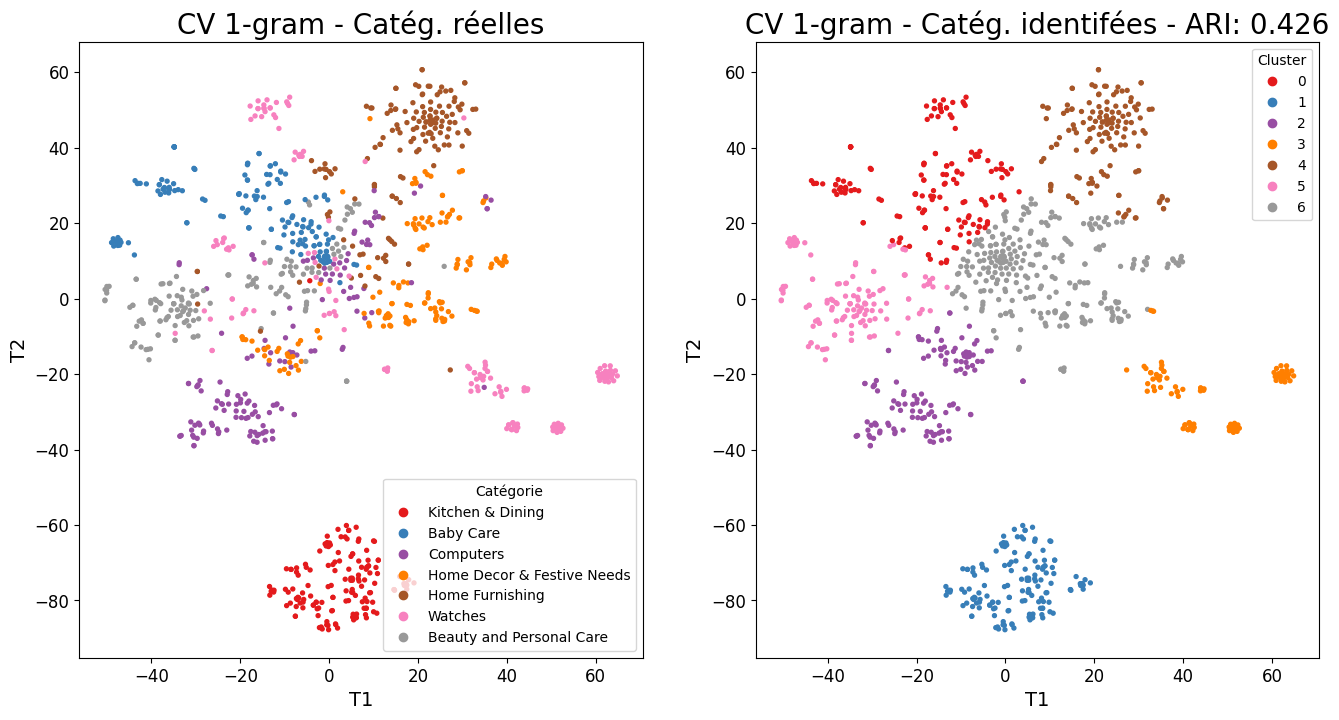

ARI : 0.4256
ARI :  0.1894 time :  11.0


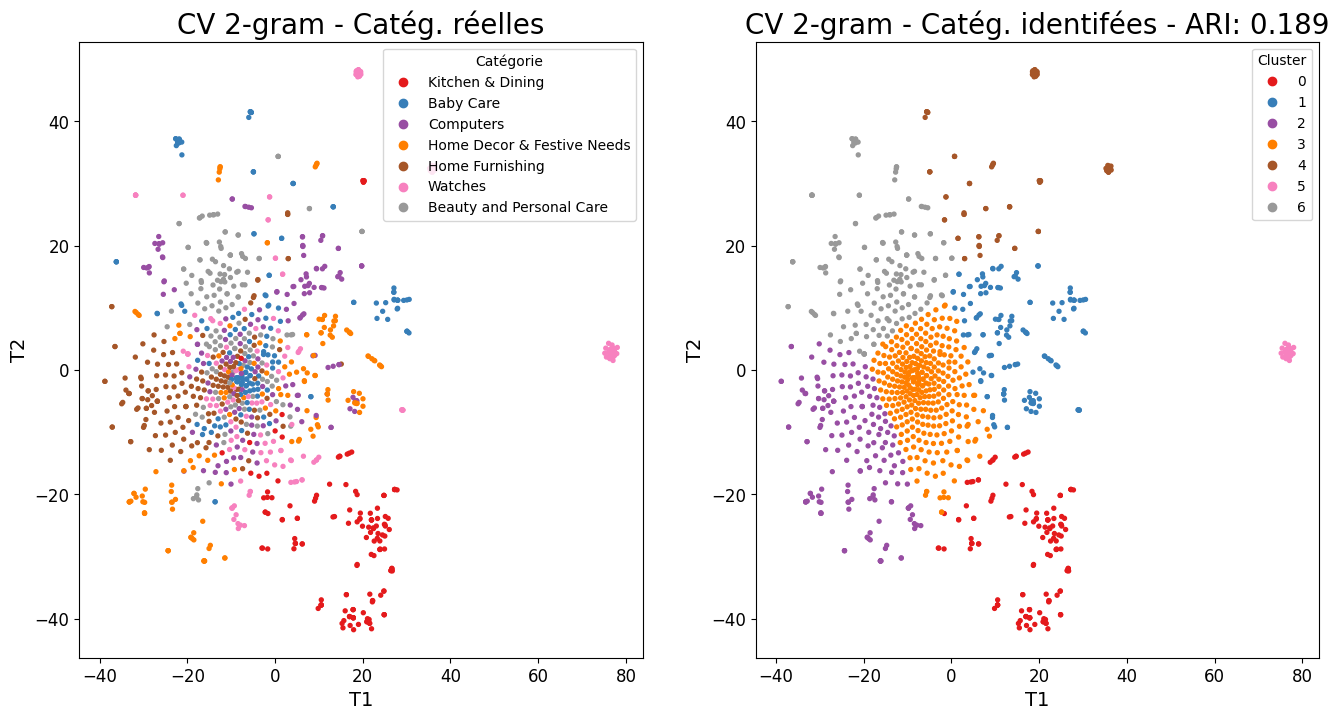

ARI : 0.1894
ARI :  0.0588 time :  11.0


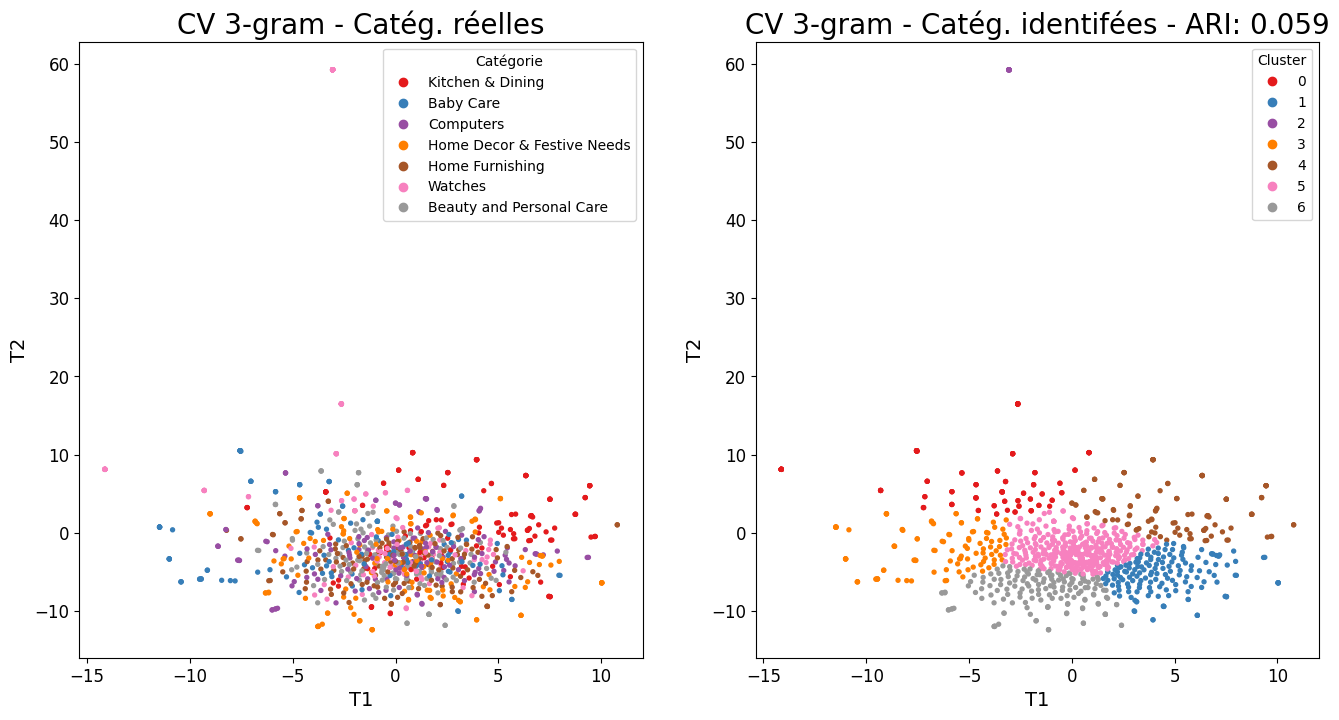

ARI : 0.0588


In [68]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ind = 0
for embeddings in [df_em_1gram, df_em_2gram, df_em_3gram]:
    ARI, X_tsne, labels = ARI_fct(embeddings, y_cat_num, n_cat, perplexity=20, n_iter=3000) # déterminés au DOE ci-dessous

    ind += 1
    feat_extractor = f'CV {ind}-gram'
    TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feat_extractor)

## TF-IDF

In [69]:
def main_tf_idf(data, ngram = 1, MAX_NB_WORDS = 75000, verbose=0):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    if verbose>0: print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [70]:
corpus_col = 'sentence_bow_stem' # 'sentence_bow_lem'

In [71]:
test_corpus = df_tk[corpus_col][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

The test corpus:  ['eleg polyest multicolor abstract eyelet door curtain featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain cm height pack curtain enhanc look curtain made high qualiti polyest featur eyelet style stitch metal make room environ romant curtain ant wrinkl anti shrinkag eleg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount specif eleg polyest multicolor abstract eyelet door curtain cm height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id color multicolor dimens length cm box content packag pack packag curtain bodi design materi polyest', 'sathiya cotton bath towel s

In [72]:
test_tfidf_em_1gram, test_tfidf_1gram = main_tf_idf(test_corpus, ngram=1, verbose=1)
print_out(test_tfidf_em_1gram, test_tfidf_1gram, ngram="Uni-gram")

tf-idf with 184 features
Uni-gram bag-of-words: 
['absorb' 'abstract' 'amount' 'ant' 'anti' 'apart' 'appeal' 'assort'
 'attent' 'bath' 'beauti' 'bed' 'bedsheet' 'bleach' 'blue' 'bodi' 'box'
 'boy' 'brand' 'bright' 'bring' 'care' 'close' 'cm' 'cold' 'color'
 'colour' 'comfort' 'contemporari' 'content' 'cotton' 'count' 'cover'
 'creat' 'curtain' 'defect' 'depth' 'deserv' 'design' 'dimens' 'door'
 'doubl' 'draw' 'dri' 'durabl' 'eleg' 'enhanc' 'enrich' 'environ'
 'eurospa' 'even' 'exchang' 'exclus' 'export' 'eyelet' 'fabric' 'face'
 'famou' 'fashion' 'fast' 'featur' 'feel' 'filter' 'fine' 'first' 'fit'
 'flat' 'floral' 'gener' 'get' 'girl' 'given' 'gold' 'goldbedi' 'good'
 'gsm' 'hand' 'heart' 'height' 'high' 'home' 'id' 'ideal' 'inch' 'iron'
 'jaipur' 'joyou' 'king' 'last' 'length' 'light' 'long' 'look' 'lot'
 'machin' 'machinewash' 'made' 'make' 'manufactur' 'materi' 'may' 'mediam'
 'men' 'metal' 'model' 'modernist' 'moment' 'morn' 'multicolor' 'name'
 'nice' 'note' 'onl' 'origion' 'pack

In [73]:
test_tfidf_em_2gram, test_tfidf_2gram = main_tf_idf(test_corpus, ngram=2, verbose=1)
print_out(test_tfidf_em_2gram, test_tfidf_2gram, ngram="Bi-gram")

tf-idf with 377 features
Bi-gram bag-of-words: 
['absorb soft' 'abstract eyelet' 'abstract polyest' 'amount specif'
 'ant wrinkl' 'anti shrinkag' 'apart first' 'appeal design' 'assort bath'
 'assort dimens' 'assort eurospa' 'attent sure' 'bath towel'
 'beauti given' 'bed sheet' 'bedsheet bed' 'bedsheet cotton'
 'bedsheet featur' 'bedsheet long' 'bedsheet nice' 'bedsheet perfact'
 'bedsheet pillow' 'bedsheet royal' 'bleach dimens' 'bleach flat'
 'bleach size' 'blue bath' 'blue size' 'bodi design' 'box content'
 'boy girl' 'brand eleg' 'brand eurospa' 'brand jaipur' 'brand last'
 'brand santosh' 'brand sathiya' 'bright modernist' 'bright sun'
 'bring exclus' 'bring home' 'care machin' 'care machinewash' 'care skin'
 'care wash' 'close even' 'cm box' 'cm fit' 'cm flat' 'cm height'
 'cm pillow' 'cm specif' 'cm weight' 'cold water' 'color assort'
 'color may' 'color multicolor' 'color red' 'color white' 'colour good'
 'comfort bed' 'contemporari eyelet' 'content packag' 'cotton bath'
 'cott

In [74]:
test_tfidf_em_3gram, test_tfidf_3gram = main_tf_idf(test_corpus, ngram=3, verbose=1)
print_out(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

tf-idf with 453 features
Tri-gram bag-of-words: 
['absorb soft durabl' 'abstract eyelet door' 'abstract polyest door'
 'amount specif eleg' 'ant wrinkl anti' 'anti shrinkag eleg'
 'apart first thing' 'appeal design surreal' 'assort bath towel'
 'assort dimens weight' 'assort eurospa bring' 'attent sure steal'
 'bath towel bath' 'bath towel featur' 'bath towel gsm' 'bath towel ideal'
 'bath towel lot' 'bath towel red' 'bath towel specif'
 'beauti given sooth' 'bed sheet hand' 'bed sheet made' 'bed sheet pillow'
 'bedsheet bed sheet' 'bedsheet cotton jaipur' 'bedsheet featur jaipur'
 'bedsheet featur santosh' 'bedsheet long specif' 'bedsheet nice look'
 'bedsheet perfact wed' 'bedsheet pillow cover' 'bedsheet royal bedsheet'
 'bleach dimens flat' 'bleach flat dri' 'bleach size king'
 'blue bath towel' 'blue size mediam' 'bodi design materi'
 'box content packag' 'boy girl men' 'boy girl model' 'brand eleg design'
 'brand eurospa gsm' 'brand jaipur print' 'brand last year'
 'brand santosh

In [75]:
# implement into the whole dataset
df_corpus = df_tk[corpus_col].tolist()
df_corpus = df_tk[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)
df_tfidf_2gram, tfidf_2gram = main_tf_idf(df_corpus, 2)
df_tfidf_3gram, tfidf_3gram = main_tf_idf(df_corpus, 3)

print(len(df_corpus))
print(df_tfidf_1gram.shape)
print(df_tfidf_2gram.shape)
print(df_tfidf_3gram.shape)

1050
(1050, 3850)
(1050, 16952)
(1050, 22060)


In [81]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [82]:
embeddings = df_tfidf_1gram
X_tsne = TSNE_calc_unsupervised(embeddings)
X = X_tsne

Time : 11.0


In [83]:
n_clusters = 7

Détermination des clusters...
Visalisation des clusters...


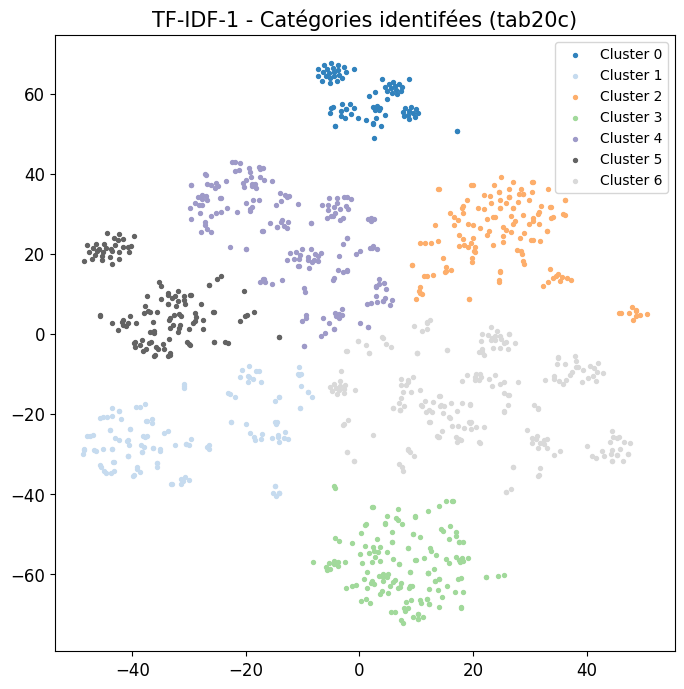

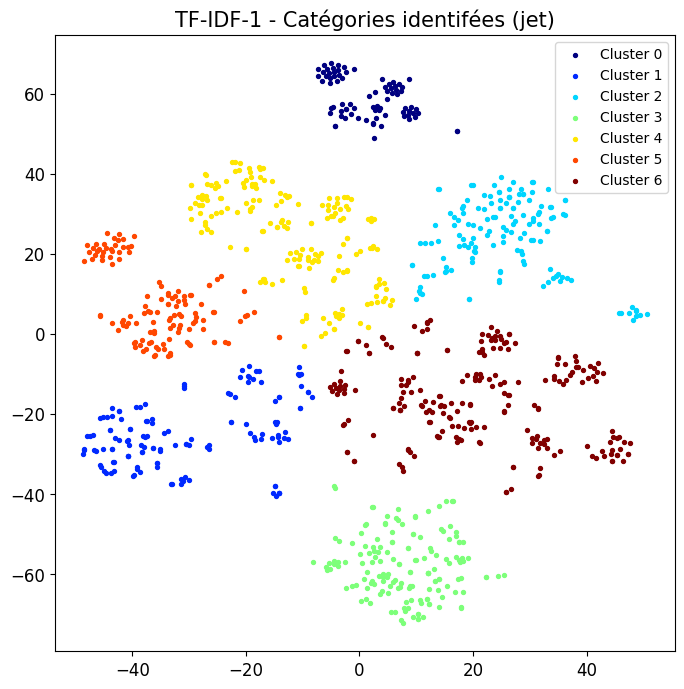

array([4, 5, 5, ..., 4, 4, 4])

In [84]:
feat_extractor = 'TF-IDF-1'
launch_text_clustering(feat_extractor, embeddings, n_clusters,
                       data_input_dir, data_output_dir,
                       df_tk, X, 'label', verbose=1)

ARI :  0.6539 time :  8.0


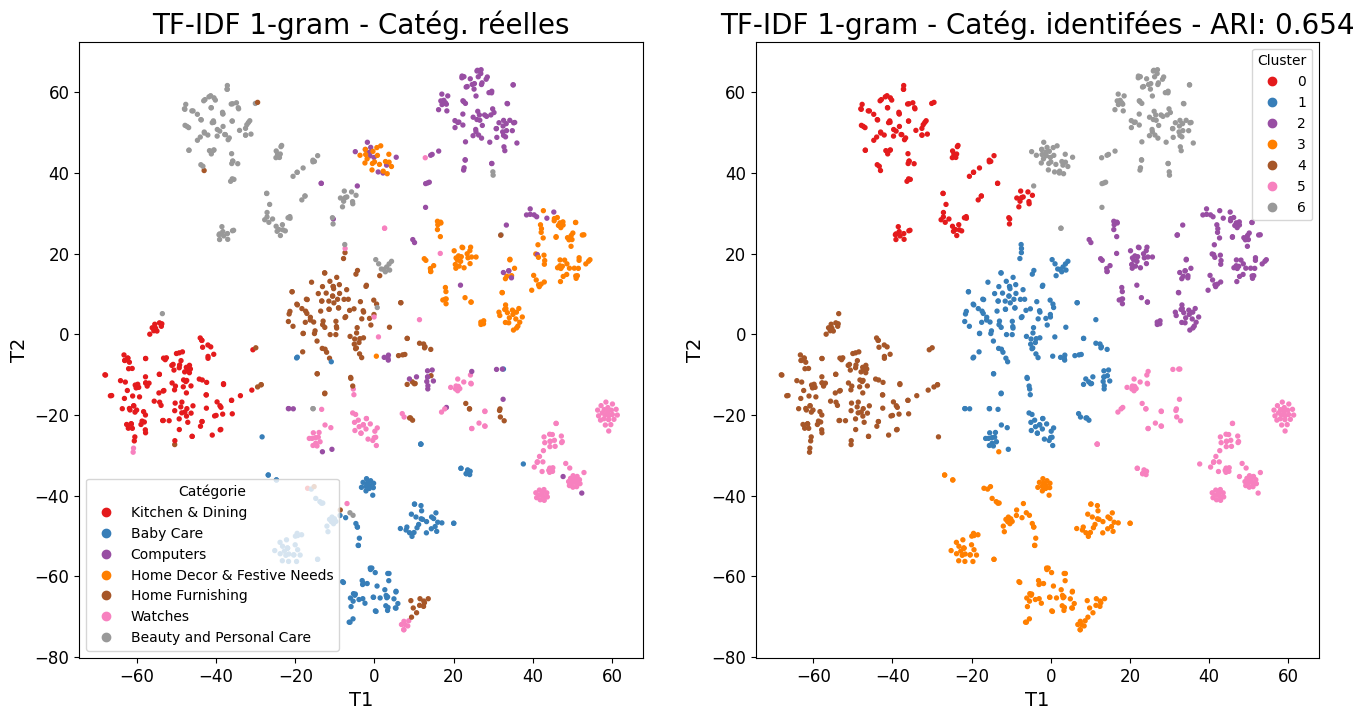

ARI : 0.6539
ARI :  0.422 time :  8.0


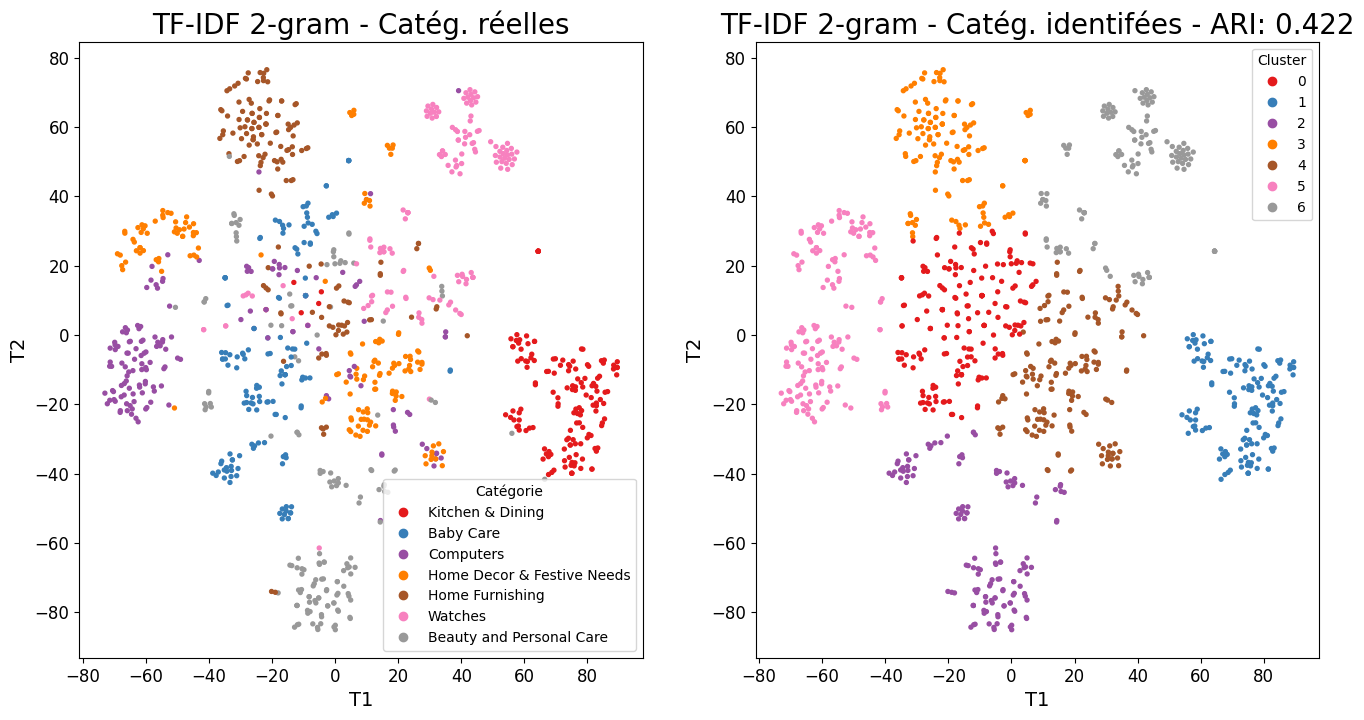

ARI : 0.4220
ARI :  0.1715 time :  13.0


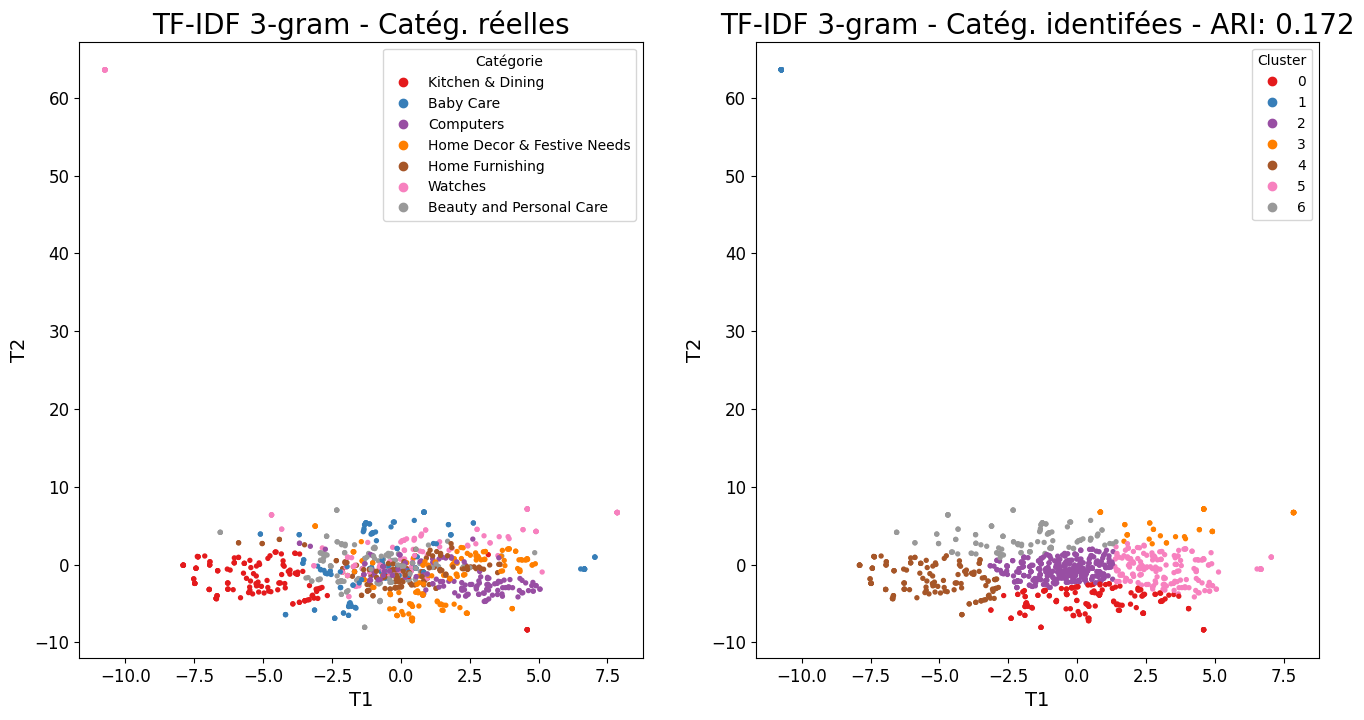

ARI : 0.1715


In [85]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ind = 0
for embeddings in [df_tfidf_1gram, df_tfidf_2gram, df_tfidf_3gram]:
    n_cat = len(np.unique(y_cat_num))
    ARI, X_tsne, labels = ARI_fct(embeddings, y_cat_num, n_cat, perplexity=20, n_iter=3000)

    ind += 1
    feature_extractor = f'TF-IDF {ind}-gram'
    TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

## Word2vec

In [86]:
def make_and_train_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=0):
    """Création et entraînement du modèle Word2Vec."""

    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                       vector_size=w2v_size,
                                       seed=42,
#                                        seed=18011975,
                                       workers=1)
    #                                    workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    if verbose>1: print("Vocabulary size: %i" % len(w2v_words))
    if verbose>1: print("Word2Vec trained")
    return w2v_model, w2v_words, model_vectors

In [87]:
def prepare_sentences(sentences, maxlen, verbose=0):
    """Préparation des sentences (tokenization)."""

    if verbose > 0: print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                maxlen=maxlen,
                                padding='post')

    num_words = len(tokenizer.word_index) + 1
    if verbose > 1: print("Number of unique words: %i" % num_words)
    return tokenizer, x_sentences, num_words

In [88]:
def make_embedding_matrix(tokenizer, w2v_size, w2v_words, model_vectors, verbose=0):
    """Création de la matrice d'embedding"""

    if verbose>0: print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0

    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i,4)
    if verbose>1: print("Word embedding rate : ", word_rate)
    if verbose>1: print("Embedding matrix: %s" % str(embedding_matrix.shape))
    return embedding_matrix, vocab_size

In [89]:
def make_model_word2vec(maxlen, vocab_size, w2v_size, x_sentences, embedding_matrix, verbose=0):
    """Création du modèle."""

    if verbose>0: print("Making Embedding model ...")
    input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
    word_input = Input(shape=(maxlen,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights=[embedding_matrix],
                               input_length=maxlen)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    if verbose>0: embed_model.summary()
    return embed_model

In [90]:
def main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=0):
    w2v_model, w2v_words, model_vectors = make_and_train_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose)
    tokenizer, x_sentences, num_words = prepare_sentences(sentences, maxlen, verbose)
    embedding_matrix, vocab_size = make_embedding_matrix(tokenizer, w2v_size, w2v_words, model_vectors, verbose)
    embed_model = make_model_word2vec(maxlen, vocab_size, w2v_size, x_sentences, embedding_matrix, verbose)
    if verbose>0: print('Predicting embeddings...')
    embeddings = embed_model.predict(x_sentences)
    if verbose>2: print(embeddings.shape)
    return embeddings

In [91]:
corpus_col = 'sentence_bow_lem'

sentences = df_tk[corpus_col].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [92]:
w2v_size = 50 # by DOE #300
w2v_window = 2
w2v_min_count = 2
w2v_epochs = 200 #100
maxlen = 50 #24 # adapt to length of sentences

In [93]:
verbose = 1
embeddings_word2vec = main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)

Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            219950    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 219,950
Trainable params: 219,950
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step


In [94]:
feat_extractor = 'word2vec'
embeddings_word2vec.shape

(1050, 50)

In [95]:
embeddings = embeddings_word2vec
X_tsne = TSNE_calc_unsupervised(embeddings)
X = X_tsne

Time : 9.0


In [96]:
if 0: 
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    n_min, n_max = 2, 20
    visu_elbow(X, n_min, n_max)

Coude magnifique en 3 mais l'inertie reste élevée. Pour comparer aux catégories de premier range, on travaille avec  n_clusters = 7.

In [97]:
n_clusters = 7

Détermination des clusters...
Visalisation des clusters...


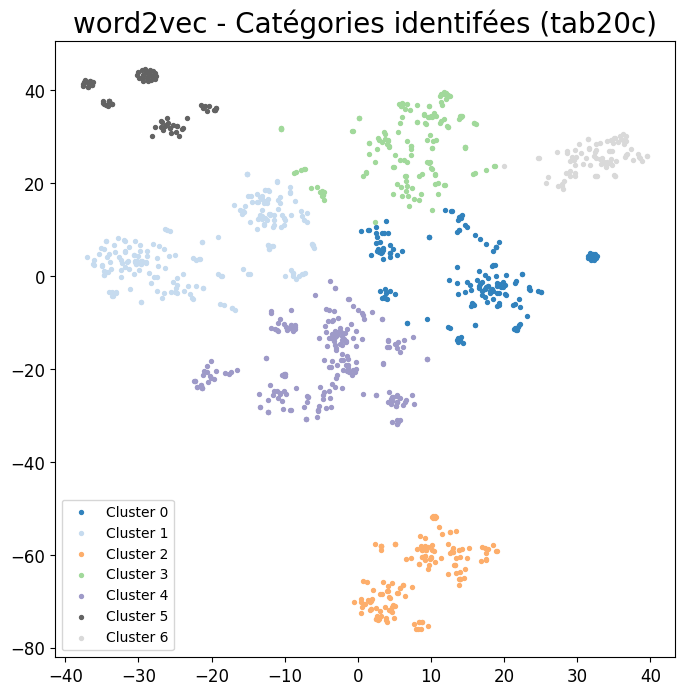

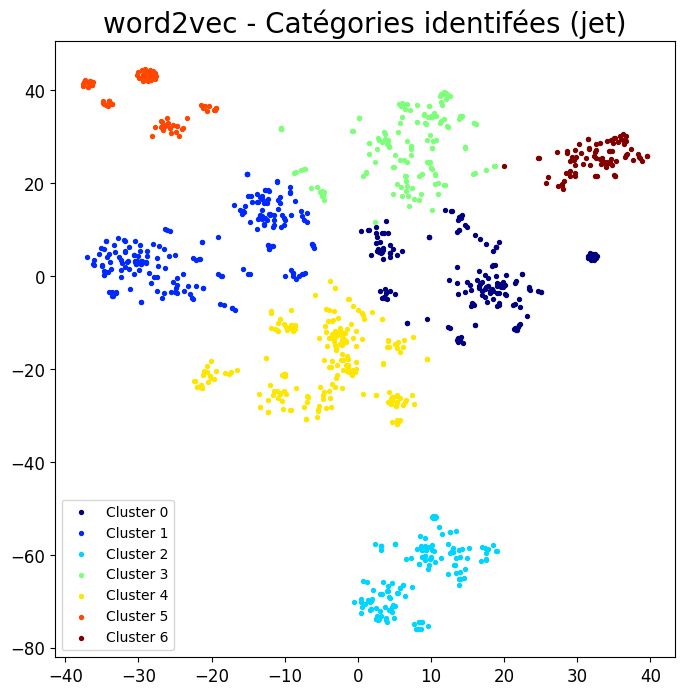

array([3, 3, 3, ..., 1, 1, 1])

In [98]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

launch_text_clustering(feat_extractor, embeddings, n_clusters,
                       data_input_dir, data_output_dir,
                       df_tk, X_tsne, 'label', verbose=1)

In [99]:
ARI, X_tsne, labels = ARI_fct(embeddings, y_cat_num, n_cat, perplexity=20, n_iter=3000)

ARI :  0.4783 time :  8.0


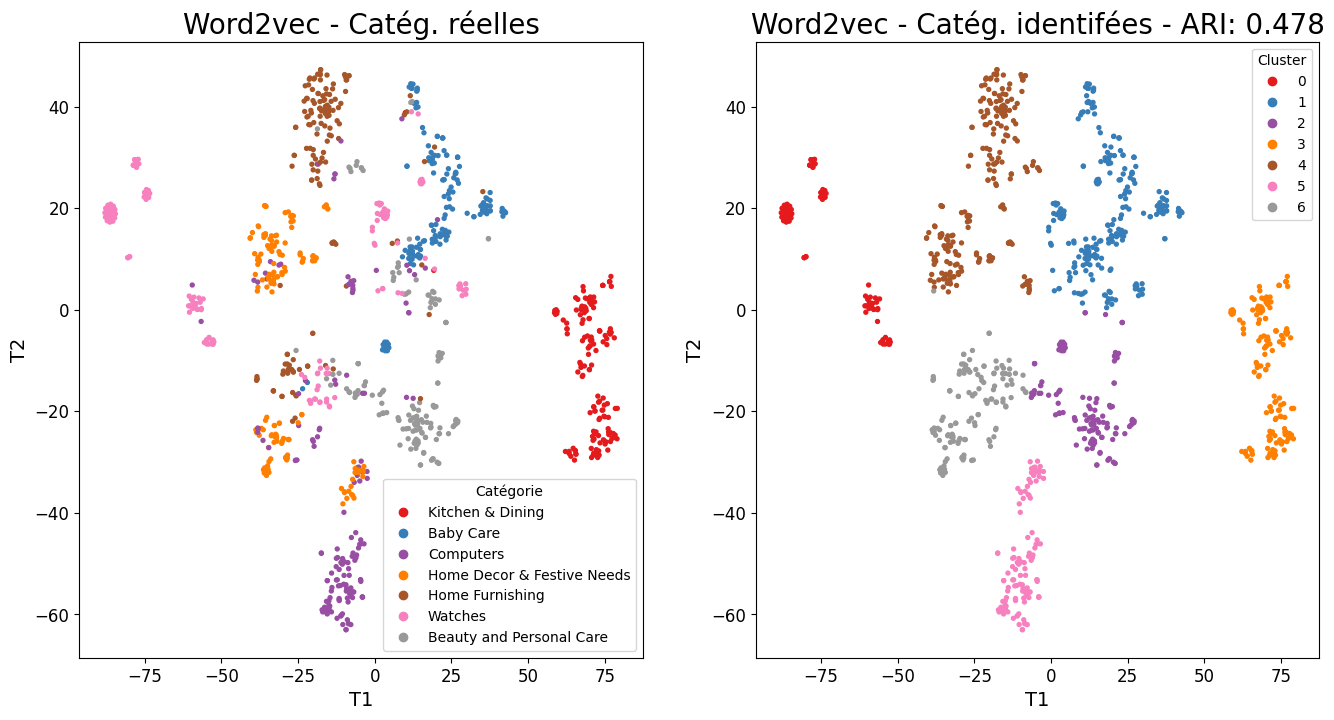

ARI : 0.4783


In [100]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'Word2vec'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

#### Nom seul avec Word2vec

In [101]:
transf_cols0 = {'name_bow': transform_bow_fct,
                'name_bow_lem': transform_bow_lem_fct,
                'name_bow_stem': transform_bow_stem_fct,
                'name_dl': transform_dl_fct}

In [102]:
df_tk = create_transformed_columns(df_tk, transf_cols0, 'product_name')

In [103]:
sentences = df_tk['product_name'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [104]:
verbose = 1
embeddings_word2vec = main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)

Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            101950    
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 101,950
Trainable params: 101,950
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step


In [105]:
ARI, X_tsne, labels = ARI_fct(embeddings_word2vec, y_cat_num, n_cat)

ARI :  0.4609 time :  10.0


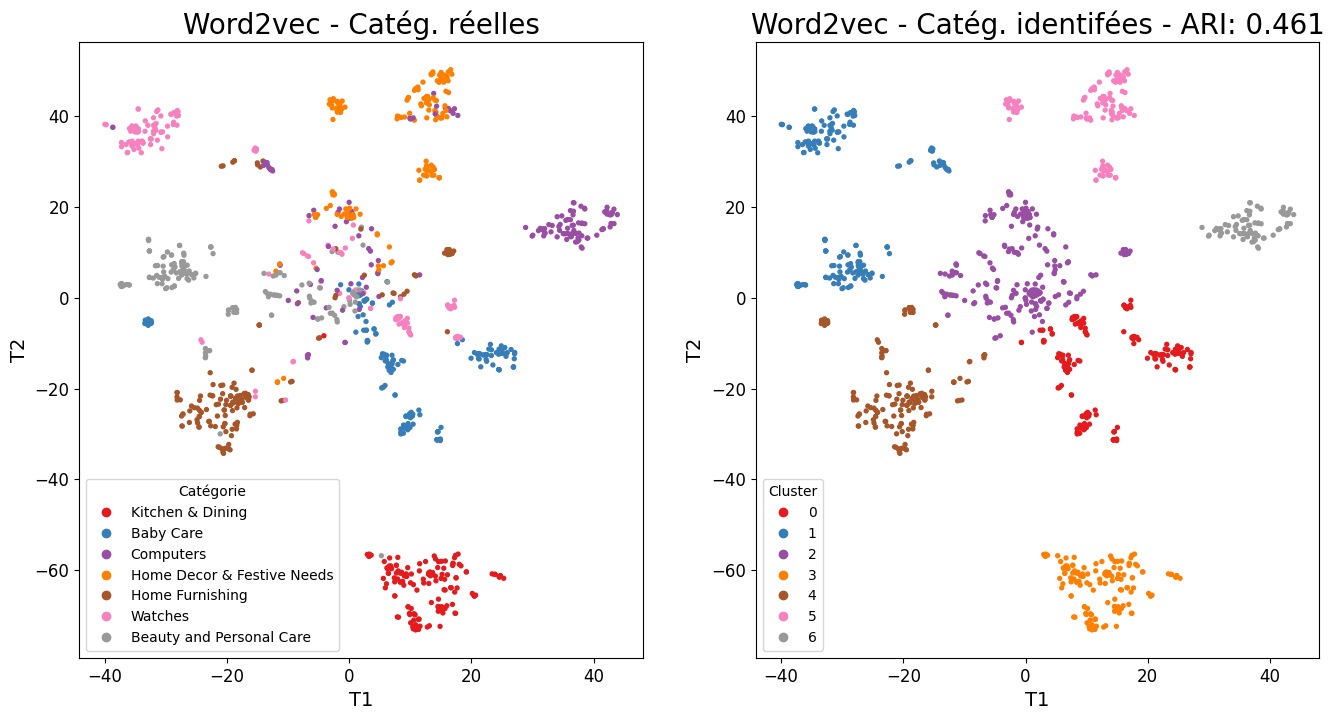

ARI : 0.4609


In [106]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'Word2vec'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Le nom de produit seul donne des résultats pas inintéressants.

## gloVe

https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z

In [149]:
# glove_input_file = data_raw_dir+"input/glove6b/glove.6B.100d.txt"
word2vec_output_file = data_input_dir+"glove6b/glove.6B.100d.txt.word2vec"

In [150]:
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=200000) 

In [151]:
def get_glove_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """Calculate average embedding value of sentence from each word vector."""
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    tokens_list = tokens_list.split(' ')
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_glove_embeddings(vectors, text, generate_missing=False, k=300):
    """create the sentence embedding."""
    embeddings = text.apply(lambda x: get_glove_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)
#     return embeddings

In [156]:
corpus_col = 'sentence_bow_lem'
embeddings_glove = np.array(get_glove_embeddings(glove_model, df_tk[corpus_col], k=300))

In [157]:
embeddings_glove.shape

(1050, 300)

In [158]:
print("Embedding matrix size", len(embeddings_glove), len(embeddings_glove[0]))
print("The sentence: \"%s\" got embedding values: " % df_tk[corpus_col][0])
print(embeddings_glove[0])

Embedding matrix size 1050 300
The sentence: "elegance polyester multicolor abstract eyelet door curtain elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain cm height pack curtain enhances look curtain made high quality polyester eyelet style stitch metal make room environment romantic curtain ant wrinkle anti shrinkage elegant home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length cm box content pac

In [159]:
import gensim

In [160]:
def main_glove(sentences, k, verbose=verbose):
    word2vec_output_file = data_input_dir+"glove6b/glove.6B.100d.txt.word2vec"
    glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=200000)
    
#     tokens = pd.Series(sentences).apply(lambda x: x.split(' '))
    embeddings_glove = get_glove_embeddings(glove_model, sentences, k=k)
    if verbose>1: print("Embedding matrix size", len(embeddings_glove), len(embeddings_glove[0]))
    return embeddings_glove

In [161]:
feat_extractor = 'GloVe'
model = glove_model
print(feat_extractor)
embeddings = embeddings_glove # model.predict(x_sentences)

X_tsne = TSNE_calc_unsupervised(embeddings)

X = X_tsne
# X = embeddings

GloVe
Time : 9.0


In [162]:
if 0:
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    n_min, n_max = 2, 20
    visu_elbow(X, n_min, n_max)

Détermination des clusters...
Visalisation des clusters...


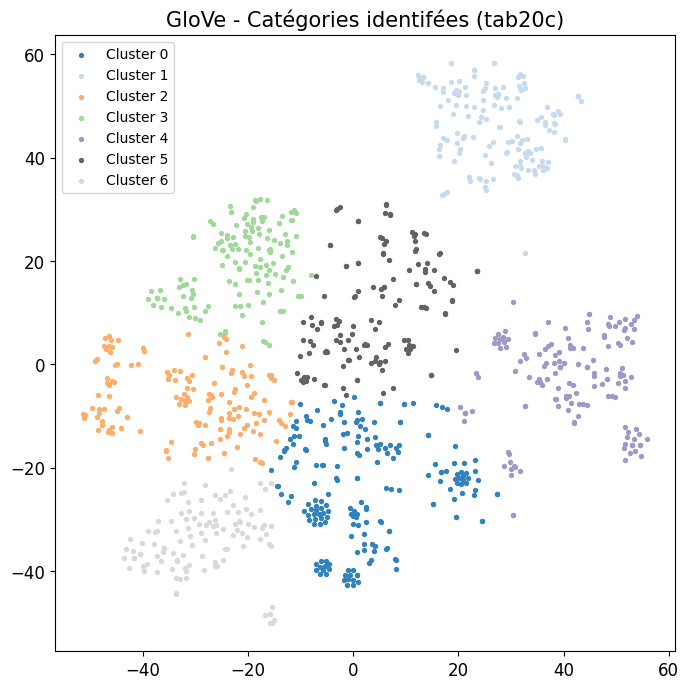

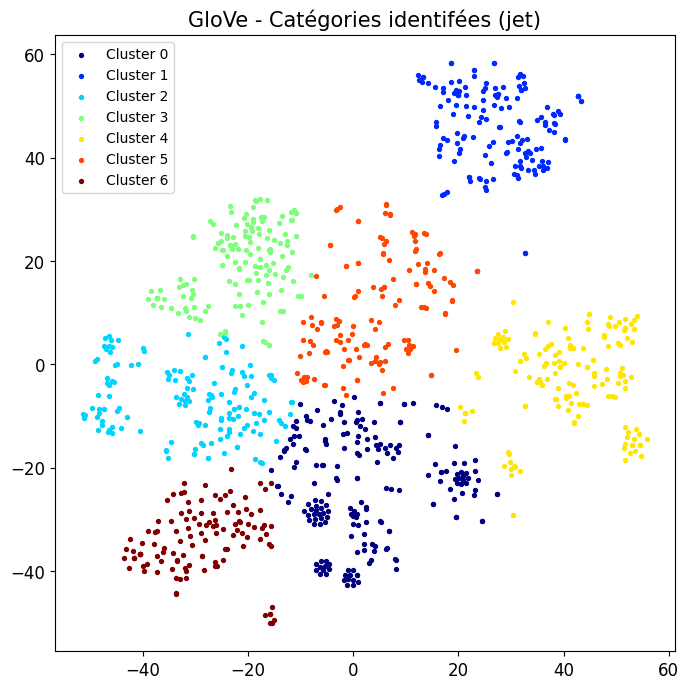

array([2, 3, 3, ..., 2, 6, 6])

In [163]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

launch_text_clustering(feat_extractor, embeddings_glove, n_clusters,
                       data_input_dir, data_output_dir,
                       df_tk, X, 'label', verbose=1)

In [164]:
ARI, X_tsne, labels = ARI_fct(embeddings_glove, y_cat_num, n_cat, perplexity=30, n_iter=3000)

ARI :  0.6421 time :  10.0


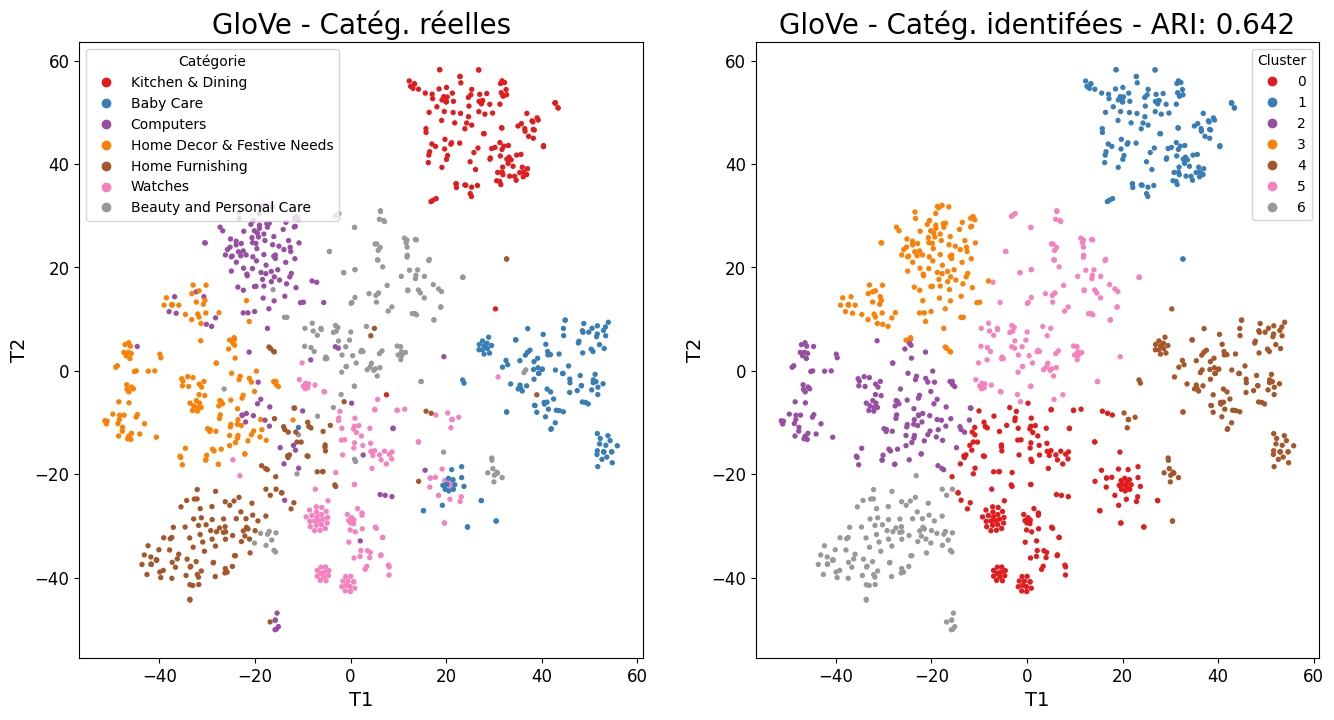

ARI : 0.6421


In [165]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'GloVe'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

## FastText

https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z

In [166]:
if 0: # .vec à télécharger et positionner correctement dans le filesystem 
    fasttext_path = "./input/fasttext-wikinews/wiki-news-300d-1M.vec"
    fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=200000)

    print(fasttext_model.similarity('mug', 'cup'))
    print(fasttext_model.similarity('mug', 'glass'))
    print(fasttext_model.similarity('mug', 'goblet'))
    print(fasttext_model.similarity('mug', 'bottle'))

    embeddings_fasttext = get_embeddings(fasttext_model, df_tk[corpus_col], k=300)

    print("Embedding matrix size", len(embeddings_fasttext), len(embeddings_fasttext[0]))
    print("The sentence: \"%s\" got embedding values: " % df_tk[corpus_col][0])
    print(embeddings_fasttext[0])

In [167]:
if 0:
    feat_extractor = 'FastText'
    model = fasttext_model

    embeddings = [] # model.predict(x_sentences)

    X_tsne = TSNE_calc_unsupervised(embeddings)

    X = X_tsne
    # X = embeddings

In [168]:
if 0 :
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 15
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    n_min, n_max = 2, 20
    visu_elbow(X, n_min, n_max)

In [169]:
n_clusters = 7 # et ouais

In [170]:
if 0:
    # %matplotlib notebook
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    launch_text_clustering(feat_extractor, model, x_sentences, n_clusters,
                           data_input_dir, data_output_dir,
                           df_tk, X, 'label', verbose=1)

In [171]:
corpus_col = 'sentence_bow_stem'

## BERT

Notebook donné dans la mission.

https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z

In [172]:
from transformers import BertTokenizer

In [173]:
print(f"Tensorflow version: {tensorflow.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")
print(f"Built with cuda   : {tf.test.is_built_with_cuda()}")

Tensorflow version: 2.10.1
Num GPUs Available: 0
Built with cuda   : True


### Fonctions communes

In [174]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF', verbose=0) :
    batch_size = b_size
    batch_size_pred = b_size
#     bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step == 0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    if verbose>0: print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT HuggingFace

#### 'bert-base-uncased'

In [175]:
max_length = 32 # by DOE #64
batch_size = 10
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
sentences = df_tk['sentence_dl'].to_list()

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a072108\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [176]:
def main_BERT_HuggingFace(sentences, max_length, batch_size, model_type, verbose=0):
    model = transformers.TFAutoModel.from_pretrained(model_type)
    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                             max_length, batch_size, mode='HF',
                                                             verbose=verbose)
    return features_bert

In [177]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 427ms/step


In [178]:
features_bert.shape

(1050, 768)

In [179]:
ARI, X_tsne, labels = ARI_fct(features_bert, y_cat_num, n_cat, perplexity=20, n_iter=3000)

ARI :  0.3944 time :  9.0


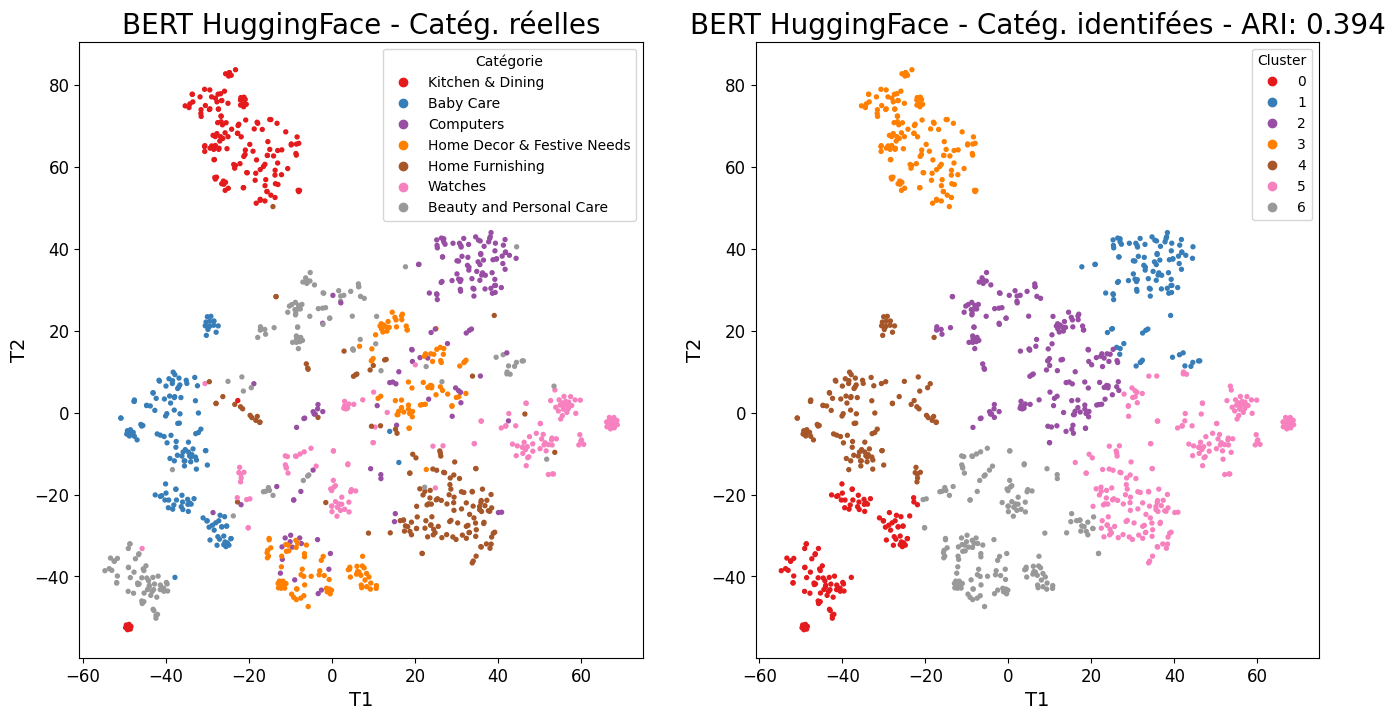

ARI : 0.3944


In [180]:
feature_extractor = 'BERT HuggingFace'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

### BERT hub Tensorflow

In [181]:
def main_BERT_TFhub(sentences, max_length, batch_size, model_type,
                    t_SNE_perplexity=30, t_SNE_n_iter=3000, verbose=0):
    model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    bert_layer = hub.KerasLayer(model_url, trainable=True)
    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                             max_length, batch_size, mode='TFhub',
                                                             verbose=verbose)
    return features_bert

In [182]:
import tensorflow_hub as hub
import tensorflow_text 

In [193]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [194]:
sentences = df_tk['sentence_dl'].to_list()

In [195]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

In [197]:
features_bert_hub = main_BERT_TFhub(sentences, max_length, batch_size, model_type)

Problèmes difficiles à résoudre avec le cache : copie de `C:\Users\a072108\AppData\Local\Temp\tfhub_modules\89e0d78326196f7e9dd113bd0eecf4c9fb022f37\*` dans `C:\Users\a072108\AppData\Local\Temp\tfhub_modules\d760773f85f64fc84ae0b47310f7cfe3bcec4868`...

In [198]:
ARI, X_tsne, labels = ARI_fct(features_bert_hub, y_cat_num, n_cat, perplexity=30, n_iter=3000)

ARI :  0.3792 time :  10.0


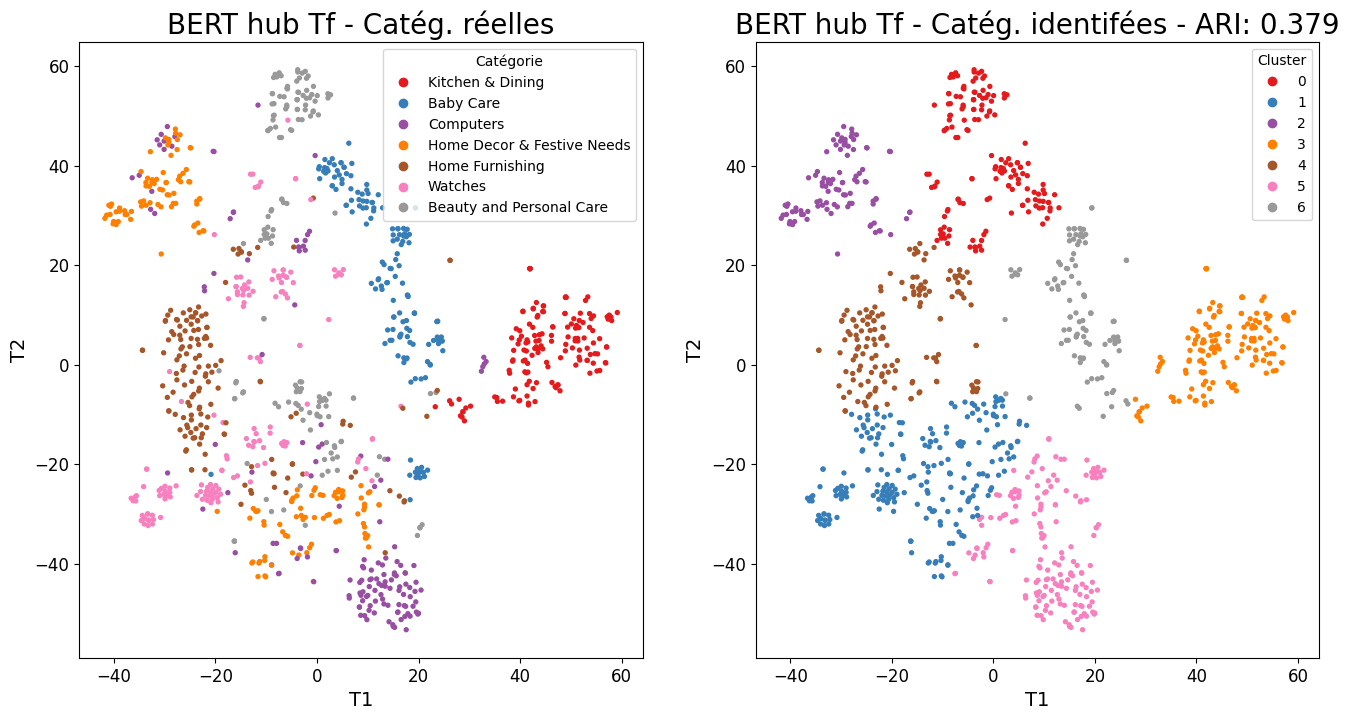

ARI : 0.3792


In [199]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'BERT hub Tf'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

## USE

In [200]:
print(f"Tensorflow version: {tensorflow.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")
print(f"Built with cuda   : {tf.test.is_built_with_cuda()}")

Tensorflow version: 2.10.1
Num GPUs Available: 0
Built with cuda   : True


In [202]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Problème avec le cache : suppression des répertoires `C:\Users\a072108\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c` et `C:\Users\a072108\AppData\Local\Temp\tfhub_modules\_063d866c06683311b44b4992fd46003be952409c`.

In [203]:
def feature_USE_fct(sentences, b_size, verbose=0) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [204]:
def main_USE(sentences, batch_size,
             t_SNE_perplexity=30, t_SNE_n_iter=3000, verbose=0):
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    features_USE = feature_USE_fct(sentences, batch_size, verbose=verbose)
    return features_USE

In [205]:
batch_size = 75 # by DOE #10
sentences = df_tk['sentence_dl'].to_list()

In [206]:
features_USE = feature_USE_fct(sentences, batch_size)

In [207]:
ARI, X_tsne, labels = ARI_fct(features_USE, y_cat_num, n_cat, perplexity=30, n_iter=3000)

ARI :  0.4712 time :  11.0


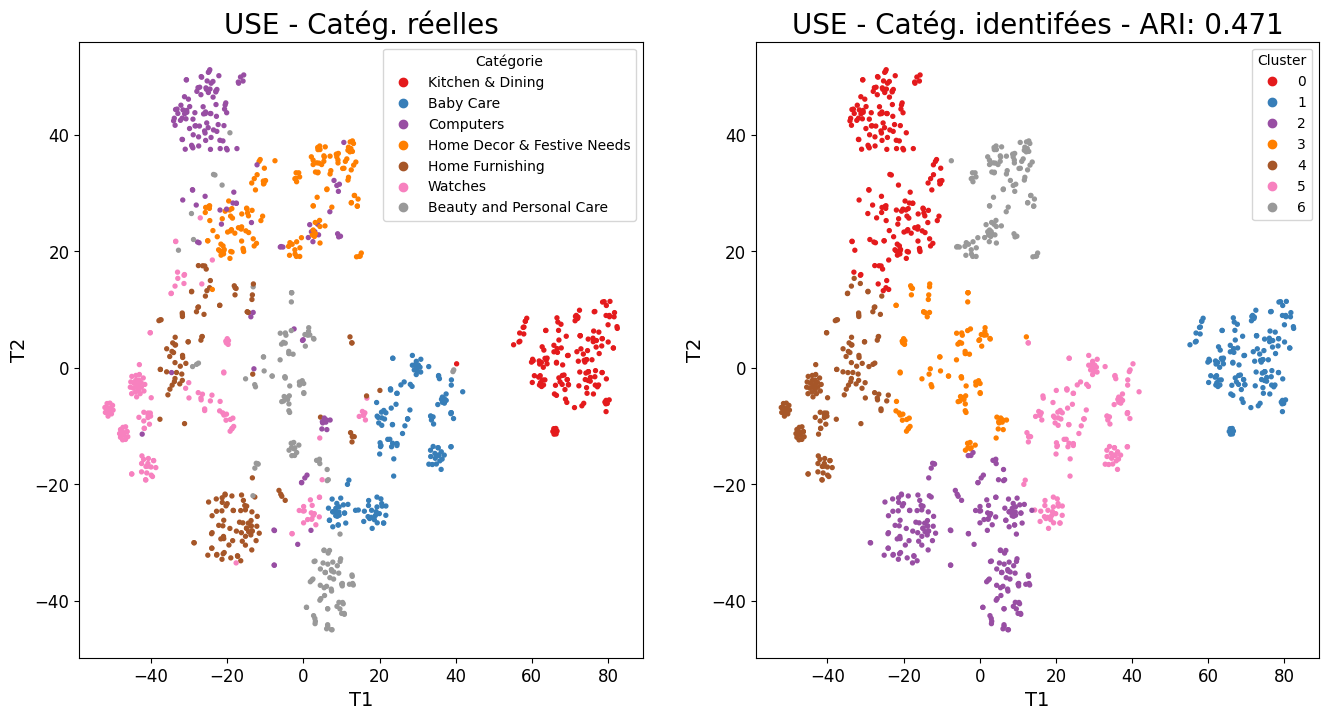

ARI : 0.4712


In [208]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'USE'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

## DOE

In [209]:
def make_grid_dict(param_grid):
    lists = [param_grid[key] for key in param_grid]
    grid = list(itertools.product(*lists))

    list_param_grid = []
    for lst in grid:
        list_param_grid.append({key:val for key, val in zip(param_grid.keys(), lst)})
        
    return list_param_grid

In [210]:
def make_doe_prepa_text(algos_prepa_text): 
    columns = ['Algorithm', 'Params']
    df_doe = pd.DataFrame(data=[], columns=columns)

    for algo in algos_prepa_text:
        new_doe = pd.DataFrame(data=[], columns=columns)
        new_doe['Params'] = make_grid_dict(algo['param_grid'])
        new_doe['Algorithm'] = algo['surname']
        df_doe = pd.concat([df_doe, new_doe], axis=0, ignore_index=True)
    return df_doe

In [246]:
param_grid_count_vect = {'ngram': [1],
                         'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                         't-SNE-perplexity': [20, 30, 100],
                         't-SNE-n_iter': [2000, 3000]
                         }

lil_param_grid_count_vect = {'ngram': [1],
                         'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                         't-SNE-perplexity': [30],
                         't-SNE-n_iter': [3000]
                         }

param_grid_tf_idf = {'ngram': [1],
                     'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                     't-SNE-perplexity': [20, 30, 100],
                     't-SNE-n_iter': [2000, 3000]
                     }
lil_param_grid_tf_idf = {'ngram': [1],
                     'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                     't-SNE-perplexity': [20, 30],
                     't-SNE-n_iter': [2000, 3000]
                     }

param_grid_w2v = {'w2v_size': [300],  # [50, 100, 300]
                  'w2v_window': [2, 5, 10],
                  'w2v_min_count': [1, 2],
                  'w2v_epochs': [100, 200],
                  'maxlen': [24, 50],  # 50, 24 # adapt to length of sentences
                  # , 'sentence_bow_stem'
                  'sentences_col': ['sentence_bow_lem'],
                  't-SNE-perplexity': [20], #[20, 30, 100]
                  't-SNE-n_iter': [3000] #[2000, 3000]
                  }
lil_param_grid_w2v = {'w2v_size': [300],  # [50, 100, 300]
                      'w2v_window': [5],
                      'w2v_min_count': [1],
                      'w2v_epochs': [100],
                      'maxlen': [24, 50],  # 50, 24 # adapt to length of sentences
                      # , 'sentence_bow_stem'
                      'sentences_col': ['sentence_bow_lem'],
                      't-SNE-perplexity': [30],
                      't-SNE-n_iter': [3000]
                      }

param_grid_glove = {'k': [300], # difficile de modifier ce paramètre
                    'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                    't-SNE-perplexity': [20, 30, 100],
                    't-SNE-n_iter': [3000]
                    }

lil_param_grid_glove = {'k': [300], # difficile de modifier ce paramètre
                    'sentences_col': ['sentence_bow_lem', 'sentence_bow_stem'],
                    't-SNE-perplexity': [30],
                    't-SNE-n_iter': [3000]
                    }

param_grid_BERT_HF = {'max_length': [32, 64],
                      'batch_size': [10],
                      'model_type': ['bert-base-uncased'],
                      'sentences_col': ['sentence_dl'],
                      't-SNE-perplexity': [20, 30],
                      't-SNE-n_iter': [3000]
                      }
lil_param_grid_BERT_HF = {'max_length': [32],
                      'batch_size': [10],
                      'model_type': ['bert-base-uncased'],
                      'sentences_col': ['sentence_dl'],
                      't-SNE-perplexity': [20, 30],
                      't-SNE-n_iter': [3000]
                      }

param_grid_BERT_TFhub = {'max_length': [64],
                         'batch_size': [10, 30],
                         'model_type': ['bert-base-uncased'],
                         'sentences_col': ['sentence_dl'],
                         't-SNE-perplexity': [30],
                         't-SNE-n_iter': [3000]
                         }
lil_param_grid_BERT_TFhub = {'max_length': [64],
                         'batch_size': [10],
                         'model_type': ['bert-base-uncased'],
                         'sentences_col': ['sentence_dl'],
                         't-SNE-perplexity': [30],
                         't-SNE-n_iter': [2000]
                         }

param_grid_USE = {'batch_size': [10, 75, 150],
                  'sentences_col': ['sentence_dl'],
                  't-SNE-perplexity': [20, 30, 100],
                  't-SNE-n_iter': [3000]
                  }
lil_param_grid_USE = {'batch_size': [150], # IL FAUT QUE CE SOIT UN SOUS-MULTIPLE DE LA TAILLE DES DONNEES !!!
                  'sentences_col': ['sentence_dl'],
                  't-SNE-perplexity': [30],
                  't-SNE-n_iter': [3000]
                  }

In [247]:
algos_prepa_text = [
                    {'surname': 'CountVectorizer',
                     'param_grid': param_grid_count_vect,
                    },
                    {'surname': 'TF-IDF',
                     'param_grid': param_grid_tf_idf,
                    },
                    {'surname': 'Word2Vec',
                     'param_grid': param_grid_w2v # lil_param_grid_w2v # param_grid_w2v
                    },
                    {'surname': 'GloVe',
                     'param_grid': param_grid_glove
                    },
                    {'surname': 'BERT-HuggingFace',
                     'param_grid': param_grid_BERT_HF
                    },
                    {'surname': 'BERT-TFhub',
                     'param_grid': param_grid_BERT_TFhub
                    },
                    {'surname': 'USE',
                     'param_grid': param_grid_USE
                    },
                   ]

Plan d'expérience affiné, après premiers résultats :

In [248]:
algos_prepa_text = [
                    {'surname': 'CountVectorizer',
                     'param_grid': lil_param_grid_count_vect,
                    },
                    {'surname': 'TF-IDF',
                     'param_grid': lil_param_grid_tf_idf,
                    },
                    {'surname': 'Word2Vec',
                     'param_grid': lil_param_grid_w2v,
                    },
                    {'surname': 'GloVe',
                     'param_grid': lil_param_grid_glove
                    },
                    {'surname': 'BERT-HuggingFace',
                     'param_grid': lil_param_grid_BERT_HF
                    },
                    {'surname': 'BERT-TFhub',
                     'param_grid': lil_param_grid_BERT_TFhub
                    },
                    {'surname': 'USE',
                     'param_grid': lil_param_grid_USE
                    },
                   ]

In [249]:
df_doe = make_doe_prepa_text(algos_prepa_text)
df_doe_init = df_doe.copy()
df_doe_init

Algorithm                                             Params
0    CountVectorizer  {'ngram': 1, 'sentences_col': 'sentence_bow_le...
1    CountVectorizer  {'ngram': 1, 'sentences_col': 'sentence_bow_st...
2             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...
3             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...
4             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...
5             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...
6             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...
7             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...
8             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...
9             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...
10          Word2Vec  {'w2v_size': 300, 'w2v_window': 5, 'w2v_min_co...
11          Word2Vec  {'w2v_size': 300, 'w2v_window': 5, 'w2v_min_co...
12             GloVe  {'k': 300, 'sentences_col': 'sentence_bow_lem'...
13             GloVe  {'k': 300, 'sentences_col': 'sentence_bow_stem...
14  BERT-HuggingFace  {'max_length': 32, 'batch_size': 10, 'model_ty...
15  BERT-HuggingFace  {'max_length': 32, 'batch_size': 10, 'model_ty...
16        BERT-TFhub  {'max_length': 64, 'batch_size': 10, 'model_ty...
17               USE  {'batch_size': 150, 'sentences_col': 'sentence...

In [250]:
def launch_doe_text_clustering(df, df_doe0, verbose=0):
    best_algo, best_X_tsne, best_labels = None, None, None
    
    df_doe = df_doe0.copy()
    
    best_ARI = 0.
    best_algo = None
    best_labels = None
    best_X_tsne = None
    best_params = None
    best_embeddings = None

    algo_name = None
    sentences_col = None
    ngram = None
    w2v_size = None
    w2v_window = None
    w2v_min_count = None
    w2v_epochs = None
    maxlen = None
    max_length = None
    batch_size = None
    model_type = None
    k = None
    # Boucle sur les problèmes à résoudre, càd les lignes de df_doe
    for ind in df_doe.index:

        problem = df_doe.loc[ind]
        algo_name_old = algo_name
        algo_name = problem['Algorithm']
        params = problem['Params']
        sentences_col_old = sentences_col
        sentences_col = params['sentences_col']
        if verbose>0: print('\n'+bcolors.BOLD+bcolors.HEADER+algo_name+'\n'+'-'*len(algo_name)+bcolors.ENDC)
        if verbose>0: print(bcolors.BOLD+f"Paramètres: {params}"+bcolors.ENDC)
        
        # Sentences
        sentences = df[sentences_col].to_list()
        sentences_df = df[sentences_col]
        sentences_p = [gensim.utils.simple_preprocess(text) for text in sentences]
        
        # t-SNE params
        t_SNE_perplexity = params['t-SNE-perplexity']
        t_SNE_n_iter = params['t-SNE-n_iter']
        
        # Word embedding
        if algo_name == 'CountVectorizer':
            ngram_old = ngram
            ngram = params['ngram']
            if (algo_name_old != algo_name) or (ngram_old != ngram) or \
                (sentences_col_old != sentences_col):
                embeddings, _ = main_count_vect(sentences, ngram, verbose=verbose)
        elif algo_name == 'TF-IDF':
            ngram_old = ngram
            ngram = params['ngram']
            if (algo_name_old != algo_name) or (ngram_old != ngram) or \
                (sentences_col_old != sentences_col):
                embeddings, _ = main_tf_idf(sentences, ngram, verbose=verbose)
        elif algo_name == 'Word2Vec':
            w2v_size_old = w2v_size
            w2v_window_old = w2v_window
            w2v_min_count_old = w2v_min_count
            w2v_epochs_old = w2v_epochs
            maxlen_old = maxlen
            w2v_size = params['w2v_size']
            w2v_window = params['w2v_window']
            w2v_min_count = params['w2v_min_count']
            w2v_epochs = params['w2v_epochs']
            maxlen = params['maxlen']
            if (algo_name_old != algo_name) or (w2v_size_old != w2v_size) or (w2v_window_old != w2v_window) \
                or (w2v_min_count_old != w2v_min_count) or (w2v_epochs_old != w2v_epochs) or (maxlen_old != maxlen) or \
                (sentences_col_old != sentences_col):
                embeddings = main_word2vec(sentences_p, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)
        elif algo_name == 'GloVe':
            k_old = k
            k = params['k']
            if (algo_name_old != algo_name) or (k_old != k):
                embeddings = np.array(main_glove(sentences_df, k, verbose=verbose))
        elif algo_name == 'BERT-HuggingFace':
            max_length_old = max_length
            batch_size_old = batch_size
            model_type_old = model_type
            max_length = params['max_length']
            batch_size = params['batch_size']
            model_type = params['model_type']
            if (algo_name_old != algo_name) or (max_length_old != max_length) or (batch_size_old != batch_size) \
                or (model_type_old != model_type) or \
                (sentences_col_old != sentences_col):
                embeddings = main_BERT_HuggingFace(sentences, max_length, batch_size, model_type, verbose=verbose)
        elif algo_name == 'BERT-TFhub':
            max_length_old = max_length
            batch_size_old = batch_size
            model_type_old = model_type
            max_length = params['max_length']
            batch_size = params['batch_size']
            model_type = params['model_type']
            if (algo_name_old != algo_name) or (max_length_old != max_length) or (batch_size_old != batch_size) \
                or (model_type_old != model_type) or \
                (sentences_col_old != sentences_col):
                embeddings = main_BERT_TFhub(sentences, max_length, batch_size, model_type, verbose=verbose)            
        elif algo_name == 'USE':
            batch_size_old = batch_size
            batch_size = params['batch_size']
            if (algo_name_old != algo_name) or (batch_size_old != batch_size) or \
                (sentences_col_old != sentences_col):
                embeddings = main_USE(sentences, batch_size, verbose=verbose)
            else:
                print("Embedding reused.")
        else:
            print(bcolors.WARNING+f"*** Algorithm name unrecognized: {algo_name}***"+bcolors.ENDC)
            continue
            
        # t-SNE
        print(t_SNE_perplexity, t_SNE_n_iter)
        X_tsne = TSNE_calc_unsupervised(embeddings, perplexity=t_SNE_perplexity, n_iter=t_SNE_n_iter)
        X = X_tsne
        # X = embeddings

        # Clustering
        n_clusters = 7
        if verbose>1: print('Détermination des clusters...')
        labels, inertia = compute_clusters(X, n_clusters)
        
        # Score ARI
        y_cat_num = df['categs_1st_num']
#         print(f"embeddings.shape = {embeddings.shape}")
#         print(f"y_cat_num.shape = {y_cat_num.shape}, labels = {labels.shape}")
        ARI = metrics.adjusted_rand_score(y_cat_num, labels)
        if verbose>0: print(f"ARI : {ARI:.4f}")
        df_doe.loc[ind,'ARI score'] = ARI
        
        if ARI >= best_ARI:
            best_ARI = ARI
            best_algo = algo_name
            best_labels = labels
            best_X_tsne = X_tsne
            best_params = params
            best_embeddings = embeddings
            lc = 'label_'+algo_name
            df_tk[lc] = labels

    if verbose>0: 
        print("\n")
        print(bcolors.BOLD+bcolors.OKGREEN+"Best embedder  : "+bcolors.ENDC+bcolors.OKGREEN+f"{best_algo}")
        print(bcolors.BOLD+bcolors.OKGREEN+"Best parameters: "+bcolors.ENDC+bcolors.OKGREEN+f"{best_params}")
        print(bcolors.BOLD+bcolors.OKGREEN+"Best ARI score : "+bcolors.ENDC+bcolors.OKGREEN+f"{best_ARI:.4f}")
        print("\n"+bcolors.ENDC)
    return best_algo, best_params, best_X_tsne, best_labels, best_ARI, best_embeddings, df_tk, df_doe

In [251]:
LAUNCH_DOE = True
APPEND_DOE = False

In [252]:
if APPEND_DOE:
    if 'df_doe_res' in globals() :
        df_doe_res_SAVE = df_doe_res.copy()
else:
    df_doe_res_SAVE = pd.DataFrame()

In [253]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

verbose = 1
if LAUNCH_DOE:
    best_algo, best_params, best_X_tsne, best_labels, best_ARI, best_embeddings, df_tk_res, df_doe_res = \
        launch_doe_text_clustering(df_tk, df_doe_init, verbose=verbose)
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    if APPEND_DOE:
        df_doe_res = pd.concat((df_doe_res_SAVE, df_doe_res))
    df_doe_res.to_csv(f"DOE_text_clustering_{timestamp}.csv", sep=';')
    %store best_algo
    %store best_params
    %store best_X_tsne
    %store best_labels
    %store best_ARI
    %store best_embeddings
    %store df_tk_res
    %store df_doe_res
else:
    %store -r best_algo
    %store -r best_params
    %store -r best_X_tsne
    %store -r best_labels
    %store -r best_ARI
    %store -r best_embeddings
    %store -r df_tk_res
    %store -r df_doe_res
    


CountVectorizer
---------------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_lem', 't-SNE-perplexity': 30, 't-SNE-n_iter': 3000}
count vectorize with 4401 features
30 3000
Time : 14.0
ARI : 0.4058

CountVectorizer
---------------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_stem', 't-SNE-perplexity': 30, 't-SNE-n_iter': 3000}
count vectorize with 3850 features
30 3000
Time : 15.0
ARI : 0.4133

TF-IDF
------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_lem', 't-SNE-perplexity': 20, 't-SNE-n_iter': 2000}
tf-idf with 4401 features
20 2000
Time : 8.0
ARI : 0.5786

TF-IDF
------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_lem', 't-SNE-perplexity': 20, 't-SNE-n_iter': 3000}
20 3000
Time : 11.0
ARI : 0.5914

TF-IDF
------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_lem', 't-SNE-perplexity': 30, 't-SNE-n_iter': 2000}
30 2000
Time : 10.0
ARI : 0.5273

TF-IDF
------
Paramètres: {'ngram': 1, 'sentences_col': 'sentence_bow_lem', 't-SNE-perp

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1/1 [==============================] - 1s 1s/step
temps traitement :  228.0
20 3000
Time : 10.0
ARI : 0.3944

BERT-HuggingFace
----------------
Paramètres: {'max_length': 32, 'batch_size': 10, 'model_type': 'bert-base-uncased', 'sentences_col': 'sentence_dl', 't-SNE-perplexity': 30, 't-SNE-n_iter': 3000}
30 3000
Time : 17.0
ARI : 0.3648

BERT-TFhub
----------
Paramètres: {'max_length': 64, 'batch_size': 10, 'model_type': 'bert-base-uncased', 'sentences_col': 'sentence_dl', 't-SNE-perplexity': 30, 't-SNE-n_iter': 2000}
temps traitement :  85.0
30 2000
Time : 8.0
ARI : 0.3652

USE
---
Paramètres: {'batch_size': 150, 'sentences_col': 'sentence_dl', 't-SNE-perplexity': 30, 't-SNE-n_iter': 3000}
30 3000
Time : 13.0
ARI : 0.4681


Best embedder  : TF-IDF
Best parameters: {'ngram': 1, 'sentences_col': 'sentence_bow_stem', 't-SNE-perplexity': 20, 't-SNE-n_iter': 3000}
Best ARI score : 0.6539


Stored 'best_algo' (str)
Stored 'best_params' (dict)
Stored 'best_X_tsne' (ndarray)
Stored 'best_labe

In [254]:
best_algo, best_params, best_ARI

('TF-IDF',
 {'ngram': 1,
  'sentences_col': 'sentence_bow_stem',
  't-SNE-perplexity': 20,
  't-SNE-n_iter': 3000},
 0.6538806921291118)

In [255]:
df_doe_res

Algorithm                                             Params  \
0    CountVectorizer  {'ngram': 1, 'sentences_col': 'sentence_bow_le...   
1    CountVectorizer  {'ngram': 1, 'sentences_col': 'sentence_bow_st...   
2             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...   
3             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...   
4             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...   
5             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_le...   
6             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...   
7             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...   
8             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...   
9             TF-IDF  {'ngram': 1, 'sentences_col': 'sentence_bow_st...   
10          Word2Vec  {'w2v_size': 300, 'w2v_window': 5, 'w2v_min_co...   
11          Word2Vec  {'w2v_size': 300, 'w2v_window': 5, 'w2v_min_co...   
12             GloVe  {'k': 300, 'sentences_col': 'sentence_bow_lem'...   
13             GloVe  {'k': 300, 'sentences_col': 'sentence_bow_stem...   
14  BERT-HuggingFace  {'max_length': 32, 'batch_size': 10, 'model_ty...   
15  BERT-HuggingFace  {'max_length': 32, 'batch_size': 10, 'model_ty...   
16        BERT-TFhub  {'max_length': 64, 'batch_size': 10, 'model_ty...   
17               USE  {'batch_size': 150, 'sentences_col': 'sentence...   

    ARI score  
0    0.405848  
1    0.413343  
2    0.578618  
3    0.591443  
4    0.527287  
5    0.527303  
6    0.647932  
7    0.653881  
8    0.581481  
9    0.586246  
10   0.373692  
11   0.497932  
12   0.642095  
13   0.642095  
14   0.394439  
15   0.364752  
16   0.365150  
17   0.468071

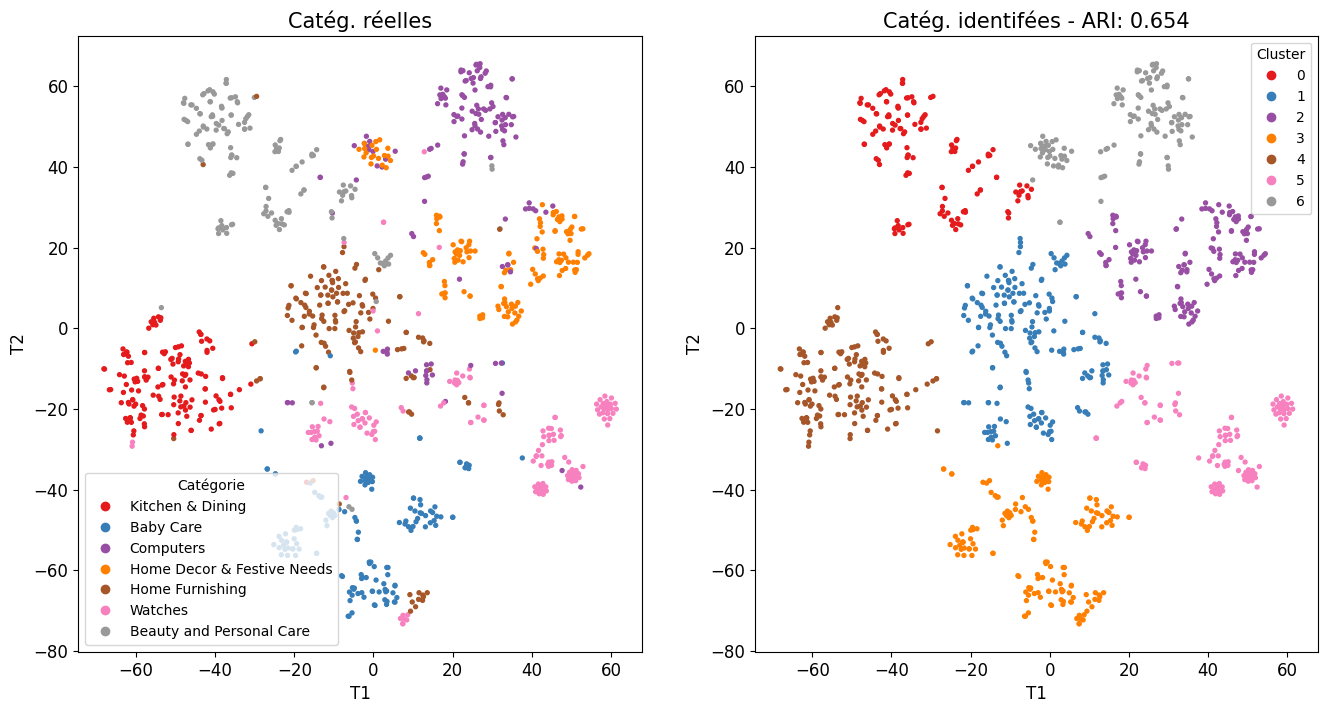

ARI : 0.6539


In [256]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

TSNE_visu_fct(best_X_tsne, l_cat, y_cat_num, best_labels, best_ARI)

Création d'une plance de visualisation pour une validation visuelle :

In [272]:
# Création des planches d'images
lc = 'label_'+best_algo
image_col = 'image'
create_output_images(df_tk_res, lc, image_col, best_algo, input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des images correspondant aux clusters...
Cluster 0 : 136 produits
Cluster 1 : 200 produits
Cluster 2 : 149 produits
Cluster 3 : 158 produits


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Cluster 4 : 158 produits
Cluster 5 : 120 produits
Cluster 6 : 129 produits


Copie des images correspondantes dans des répertoires séparés :

In [273]:
create_output_dir_images(df_tk_res, lc, image_col, best_algo, 
                         input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des répertoires d'images correspondant aux clusters...
Cluster 0 : 136 produits
Cluster 1 : 200 produits
Cluster 2 : 149 produits
Cluster 3 : 158 produits
Cluster 4 : 158 produits
Cluster 5 : 120 produits
Cluster 6 : 129 produits


# Textes - Classification

Même si le projet ne demande pas de développer une classification supervisée, nous allons évaluer les performances obtenues avec les features textuelles pour ce type de classification.

## Word2vec

In [274]:
X_enc = embeddings_word2vec
y_enc = df_tk['categs_1st_num']

In [275]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)

In [276]:
# gamma = [1., 5., 10.]
# min_child_weight = [5., 7.]
# colsample_bytree = [0.5, 1.]
# max_depth = [1, 3, 6]
# alpha = [1., 100., 200.]
param_grid_xgbc = {'n_estimators': [200], #[20, 50, 100, 200]
                   'learning_rate': [0.1], #[0.01, 0.1, 0.3]
                   'subsample': [0.5], #[0.5, 0.7, 1.]
                  }
param_grid_rfc = {'n_estimators': [200], #[20, 50, 100, 200]
                  'max_depth': [None], #[None, 1, 2, 5],
                  'min_samples_split': [2], #[2, 5, 10], 
                 }

In [277]:
mdl = GridSearchCV(
#                    XGBClassifier(), param_grid_xgbc,
                   RandomForestClassifier(), param_grid_rfc,
                   cv=5,
                   scoring='accuracy'
                   )

In [278]:
mdl.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'min_samples_split': [2],
                         'n_estimators': [200]},
             scoring='accuracy')

In [279]:
main_score_val = mdl.cv_results_['mean_test_score'].max()

In [280]:
main_score_val

0.8916666666666666

In [281]:
mdl.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [282]:
y_pred = mdl.predict(X_test)
s = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy sur test set = {s:.4f}")

Accuracy sur test set = 0.8952


## Tous les embeddings

In [283]:
y_enc = df_tk['categs_1st_num']
s = 0.
for embeddings, name in [
                         [df_em_1gram, 'df_em_1gram'],
#                          [df_em_2gram, 'df_em_2gram'],
#                          [df_em_3gram, 'df_em_3gram'],
                         [df_tfidf_1gram, 'df_tfidf_1gram'],
#                          [df_tfidf_2gram, 'df_tfidf_2gram'],
#                          [df_tfidf_3gram, 'df_tfidf_3gram'],
                         [embeddings_word2vec, 'embeddings_word2vec'],
                         [embeddings_glove, 'embeddings_glove'],
                         [features_bert, 'features_bert'],
                         [features_bert_hub, 'features_bert_hub'],
                         [features_USE, 'features_USE'],
                         ]:
    print(bcolors.BOLD+name+'\n'+'-'*len(name)+bcolors.ENDC)
    X_enc = embeddings

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=18011975)  # 18011975 , stratify=y_enc


    time1 = time.time()
    mdl = GridSearchCV(
#                        XGBClassifier(), param_grid_xgbc,
                       RandomForestClassifier(), param_grid_rfc,
                       cv=5,
                       scoring='accuracy'
                       )
    mdl.fit(X_train, y_train)
    main_score_val = mdl.cv_results_['mean_test_score'].max()
#     name = varnameis(embeddings)
    print(f"main_score_val = {main_score_val:.4f}")
    print(f"best_params_ = {mdl.best_params_}")
    
#     mdl.best_estimator_.fit(X_test, y_train)
    y_test_pred = mdl.best_estimator_.predict(X_test)
    time2 = time.time() - time1
    s_old = s
    s = metrics.accuracy_score(y_test, y_test_pred)
    
    y_train_pred = mdl.best_estimator_.predict(X_train)
    s1 = metrics.accuracy_score(y_train, y_train_pred)
    print(f"Accuracy sur train set = {s1:.4f}")
    print(f"Accuracy sur test set  = {s:.4f}, elapsed = {time2:.1f}")
    if s > s_old:
        best_model = mdl.best_estimator_
        best_embeddings = embeddings
        best_embeddings_name = name
        best_accuray = s
    print('\n')

df_em_1gram
-----------
main_score_val = 0.9274
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.9238, elapsed = 17.8


df_tfidf_1gram
--------------
main_score_val = 0.9202
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.9381, elapsed = 19.1


embeddings_word2vec
-------------------
main_score_val = 0.8905
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 0.9929
Accuracy sur test set  = 0.9000, elapsed = 11.8


embeddings_glove
----------------
main_score_val = 0.8976
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 0.9952
Accuracy sur test set  = 0.9095, elapsed = 29.5


features_bert
-------------
main_score_val = 0.8690
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 2

In [284]:
best_embeddings_name

'features_USE'

Même si le projet ne demande pas de développer une classification supervisée, on peut se rassurer sur les performances potentielles obtenues avec les features textuelles pour une telle classification.

# Exports

In [287]:
with open(data_processed_dir+'data_01.pkl', 'wb') as output:
    pickle.dump(data_01, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'best_embeddings.pkl', 'wb') as output:
    pickle.dump(best_embeddings, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'df_em_1gram.pkl', 'wb') as output:
    pickle.dump(df_em_1gram, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'df_tfidf_1gram.pkl', 'wb') as output:
    pickle.dump(df_tfidf_1gram, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'embeddings_word2vec.pkl', 'wb') as output:
    pickle.dump(embeddings_word2vec, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'embeddings_glove.pkl', 'wb') as output:
    pickle.dump(embeddings_glove, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'features_bert.pkl', 'wb') as output:
    pickle.dump(features_bert, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'features_bert_hub.pkl', 'wb') as output:
    pickle.dump(features_bert_hub, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'features_USE.pkl', 'wb') as output:
    pickle.dump(features_USE, output, pickle.HIGHEST_PROTOCOL)

with open(data_processed_dir+'df_tk_res.pkl', 'wb') as output:
    pickle.dump(df_tk_res, output, pickle.HIGHEST_PROTOCOL)    